<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries (Solution)

--- 



In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import requests
from tqdm import tqdm
import bs4
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, classification_report, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
pd.set_option('display.max_columns', None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import multiprocessing as mp
import requests
import sys
import threading
from timeit import Timer

In [4]:
# execute the get request
r = requests.get(URL)
# create the beautifulsoup object
soup = BeautifulSoup(r.content, 'html.parser')

In [5]:
# check the contents
from pprint import pprint
# print(soup.text)

In [6]:
soup.find('a', {'class': 'turnstileLink'})["title"].strip()

'Data Scientist'

In [7]:
f = open('test.html', 'w')
f.write(soup.text)
f.close()

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some of the more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above.

In [8]:
# Strip text and return none if no results
def extract_title_from_result(entry):
    try:
        job = entry.find('a', {'class': 'turnstileLink'})["title"].strip()
    except:
        job = None
    return job


def extract_company_from_result(entry):
    try:
        company = entry.find('span', {'class': 'company'}).text.strip()
    except:
        company = None
    return company


def extract_location_from_result(entry):
    try:
        location = entry.find('span', {'class': 'location'}).text.strip()
    except:
        location = None
    return location


def extract_salary_from_result(entry):
    try:
        salary = entry.find('span', {"class": 'no-wrap'}).text.strip()
    except:
        salary = None
    return salary


def extract_summary_from_result(entry):
    try:
        salary = entry.find('span', {"class": 'summary'}).text.strip()
    except:
        salary = None
    return salary


def iter_soup(soup):
    jobs = []
    for item in soup.find_all('div', {"data-tn-component": "organicJob"}):
        job = extract_title_from_result(item)
        company = extract_company_from_result(item)
        location = extract_location_from_result(item)
        salary = extract_salary_from_result(item)
        summary = extract_summary_from_result(item)
        jobs.append((job, company, location, salary, summary))

    return jobs

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results: the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try different cities). The second controls where in the results to start and gives 10 results (so we can keep incrementing this by 10 to move further within the list).

#### Complete the following code to collect results from multiple cities and start points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [9]:
YOUR_CITY = 'Los+Angeles'

In [10]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
# Set this to a high-value (5000) to generate more results.
max_results_per_city = 10
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []
count = 0
cities = ['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle',
          'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh',
          'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]

cities.sort()

for city in tqdm(cities):
    # Verbosity (to see at what stage it is as it's iterating)
    count += 1.0
    completion = np.round(count * 100 / len(cities), decimals=1)
    for start in range(0, max_results_per_city+1, 10):
        # Grab the results from the request (as above)
        # Append to the full set of results
        r = requests.get(url_template.format(city, start))
        soup = BeautifulSoup(r.text, 'html.parser')
        results += iter_soup(soup)
        next_previous = soup.find_all('span', {'class': 'np'})
        # Check if the result page is the last one
        if len(next_previous) == 1 and'Previous' in next_previous[0].text:
            break
#     print(("Scraping of {0} done. {1}% of total job completed.".format(city, completion)))
print ("Scraping finished.")

 12%|█▎        | 2/16 [00:03<00:26,  1.92s/it]


KeyboardInterrupt: 

## Requests being parallelized

In [11]:
# The multiprocesing module requires a helper for the requests:
def request_(city_, index_, return_dict):
    results = []
    # Grab the results from the request (as above)
    # Append to the full set of results
    r = requests.get(url_template.format(city_, index_))
    soup = BeautifulSoup(r.text, 'html.parser')
    results = iter_soup(soup)
#     next_previous = soup.find_all('span', {'class': 'np'})
    # Check if the result page is the last one
    k = city_+'_'+str(index_)
    return_dict[k] = results

In [12]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"

In [13]:
# the multiprocessing part (100)
# using the manager() subclass from the module to gather the results
jobs = []
manager = mp.Manager()
return_dict = manager.dict()
max_results_per_city=100
for c in tqdm(cities):
    for i in range(0, max_results_per_city+1, 10):    
        thread = threading.Thread(name=i, target=request_, args=(c, i, return_dict))
        jobs.append(thread)
        thread.start()
print("Waiting for threads to finish execution.")
for j in jobs:
    j.join()

100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Waiting for threads to finish execution.


In [14]:
list(return_dict.keys())

['Atlanta_20',
 'Austin_40',
 'Austin_0',
 'Atlanta_40',
 'Austin_30',
 'Atlanta_10',
 'Atlanta_50',
 'Dallas_40',
 'Denver_90',
 'Austin_100',
 'Chicago_60',
 'Chicago_70',
 'Atlanta_70',
 'Austin_60',
 'Chicago_10',
 'Dallas_100',
 'Chicago_90',
 'Houston_30',
 'Denver_20',
 'Austin_50',
 'Denver_0',
 'Austin_90',
 'Chicago_80',
 'Chicago_0',
 'Dallas_20',
 'Chicago_30',
 'Dallas_60',
 'Atlanta_0',
 'Atlanta_100',
 'Atlanta_80',
 'Chicago_100',
 'Denver_10',
 'Atlanta_60',
 'Chicago_20',
 'Chicago_50',
 'Los+Angeles_60',
 'Houston_70',
 'Austin_10',
 'Denver_40',
 'Houston_0',
 'Austin_20',
 'Atlanta_90',
 'Chicago_40',
 'Los+Angeles_100',
 'Dallas_70',
 'Dallas_30',
 'Dallas_10',
 'Houston_40',
 'Austin_80',
 'Houston_10',
 'Denver_50',
 'Denver_60',
 'Denver_100',
 'Dallas_0',
 'Austin_70',
 'New+York_30',
 'Atlanta_30',
 'Dallas_50',
 'Houston_60',
 'Denver_70',
 'Denver_80',
 'Miami_30',
 'Los+Angeles_90',
 'Miami_90',
 'Houston_90',
 'Los+Angeles_40',
 'Houston_50',
 'New+York_1

In [15]:
return_dict['Austin_20']

[('Senior Data Scientist',
  'RetailMeNot, Inc.',
  'Austin, TX',
  None,
  'In this role you will collaborate with a multidisciplinary team of data scientists, software engineers, data engineers, business analysts, product managers, and...'),
 ('Data Scientist -Transit',
  'Cubic Corporation',
  'Austin, TX',
  None,
  'Experience with machine learning, data modeling, data integration, data mining, statistical modeling, and general data science best practices....'),
 ('Data Scientist - Marketing (Programmatic Emailing)',
  'HomeAway',
  'Austin, TX',
  None,
  'Assist others with data discovery and data preparation phase. We are looking for excellent Data Scientists to join our growing 20+ strong team....'),
 ('Environmental Scientist and Environmental Scientist Senior',
  'City of Austin',
  'Austin, TX 78702 (Rosewood area)',
  '$28.95 - $37.50 an hour',
  'Environmental Scientist Senior:. 5.Interpret water quality, flow and biological data. 7.Organize and prepare reports and memos 

In [16]:
r_ = []
for k in list(return_dict.keys()):
    r_.extend(return_dict[k])

In [17]:
len(r_)

1645

#### To reload all the data:

In [12]:
all_cities = ['Anaheim', 'Atlanta', 'Aurora', 'Austin', 'Bellevue', 'Belmont', 'Berkeley', 'Bothell', 'Boulder', 'Broomfield', 'Buckley AFB', 'Buffalo', 'Chicago', 'Cobleskill', 'Conshohocken', 'Coral Gables', 'Cupertino', 'Dallas', 'Denver', 'Des Plaines', 'Duluth', 'El Segundo', 'Englewood', 'Farmers Branch', 'Hillsboro', 'Horsham', 'Houston', 'Hyde Park', 'Kennesaw', 'Lakewood', 'Lawrenceville', 'League City', 'Los Altos', 'Los Angeles', 'Los+Angeles', 'Metuchen', 'Miami',
              'Milpitas', 'Mount Laurel', 'Mountain View', 'New York', 'New+York', 'Northbrook', 'Oakland', 'Palo Alto', 'Philadelphia', 'Phoenix', 'Piscataway', 'Pittsburgh', 'Plymouth Meeting', 'Portland', 'Princeton', 'Redmond', 'Redwood City', 'Richmond', 'San Diego', 'San Francisco', 'San Jose', 'San Mateo', 'San+Francisco', 'Santa Clara', 'Santa Monica', 'Scottsdale', 'Seattle', 'Stony Brook', 'Sunnyvale', 'Torrance', 'Trenton', 'Venice', 'Wayne', 'Westminster', 'Wilmington', 'Yardley']

In [24]:
# load files from the data folder
file_ = []
max_results_per_city = 10000
feature_names = ['position', 'company', 'location', 'salary', 'summary']
df = pd.DataFrame(columns=feature_names)


for city in all_cities:
    try:
        filename = './data/indeed-scraped-job-postings-' + \
            city + '-max-' + str(max_results_per_city) + '.csv'
        df = pd.read_csv(filename)
#         print df.shape
        jobs_raw = jobs_raw.append(df)
    except:
        print("Warning cannot load {0}".format(city))
jobs_raw.reset_index(drop=True, inplace=True)

Warning cannot load Duluth
Warning cannot load Hyde Park


In [25]:
jobs_raw.shape

(38954, 5)

In [27]:
jobs_raw.head()

,position,company,location,salary,summary
0,Research Scientist,MacDermid Inc.,"Atlanta, GA",None,Includes complete data analysis and makes reco...
1,Principal-Advanced Analytics,AT&T,"Atlanta, GA",None,"Supports data selection, extraction, and clean..."
2,Epidemiologist,Centers for Disease Control and Prevention,"Atlanta, GA","$77,058 - $119,121 a year","Data Management, Analysis, and Interpretation...."
3,"Post-Doctoral Fellow- Medical Imaging, Machine...",Emory University,"Atlanta, GA",None,DESCRIPTION JOB DESCRIPTION: Helps design and ...
4,Environmental Health Fellowship - CDC,Oak Ridge Associated Universities,"Atlanta, GA",None,Learn how to use various software programs to ...


#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [15]:
# # create a data frame from the scraped data
# feature_names = ['position', 'company', 'location', 'salary', 'summary']
# jobs_raw = pd.DataFrame(results, columns=feature_names)
# print(jobs_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
position    50 non-null object
company     50 non-null object
location    50 non-null object
salary      2 non-null object
summary     50 non-null object
dtypes: object(5)
memory usage: 2.0+ KB
None


In [27]:
jobs_raw.head()

,position,company,location,salary,summary
0,Scrum Master,Thermo Fisher Scientific,"Austin, TX 73344",None,"Ability to define business processes, data nee..."
1,Principal Data Scientist,BlackLocus,"Austin, TX 78701 (Downtown area)",None,Experience managing groups of PhD level data s...
2,Senior Civil Engineer - TRN,Burns & McDonnell,"Austin, TX 78769 (Windsor Road area)",None,May assess feasibility or soundness of propose...
3,Sales Engineer,Cognitive Scale,"Austin, TX",None,Ability to face client technical architects an...
4,Data Analytics Implementation Manager - Digita...,Siemens AG,"Austin, TX",None,"8+ years of experience in transport, but also ..."


Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [28]:
def cleaning_(jobs_raw):

    # print the dimensions of the dataframe before the cleaning
    print("Before the cleaning")
    print("-" * 45)
    print("Observations:\t{}\nFeatures:\t{}\n\n".format(*jobs_raw.shape))

    # drop any duplicated entry
    jobs_no_dups = jobs_raw.drop_duplicates()
    print("After dropping duplicated entries")
    print("-" * 45)
    print("Observations:\t{}\nFeatures:\t{}\n\n".format(*jobs_no_dups.shape))

    # drop entries with null values
    jobs_no_null = jobs_no_dups[jobs_no_dups['salary'].notnull()]
    print("After dropping duplicated null values")
    print("-" * 45)
    print("Observations:\t{}\nFeatures:\t{}\n\n".format(*jobs_no_null.shape))

    # remove blank spaces and \n trailing and preceding the values
    # jobs['salary'] = jobs['salary'].str.strip()

    # keep only the entries containing annual salary
    jobs_year_sal = jobs_no_null[jobs_no_null['salary'].str.contains('year')]
    print("Keeping only entries with annual salary")
    print("-" * 45)
    print("Observations:\t{}\nFeatures:\t{}\n\n".format(*jobs_year_sal.shape))

    # keep only the entries non estimated salary
    jobs = jobs_year_sal[~jobs_year_sal['salary'].str.contains('Estimated')]
    print("Keeping only the entries non estimated salary")
    print("-" * 45)
    print("Observations:\t{}\nFeatures:\t{}\n\n".format(*jobs.shape))

    return jobs

In [29]:
jobs = cleaning_(jobs_raw)

Before the cleaning
---------------------------------------------
Observations:	38954
Features:	5


After dropping duplicated entries
---------------------------------------------
Observations:	9040
Features:	5


After dropping duplicated null values
---------------------------------------------
Observations:	986
Features:	5


Keeping only entries with annual salary
---------------------------------------------
Observations:	834
Features:	5


Keeping only the entries non estimated salary
---------------------------------------------
Observations:	406
Features:	5




In [31]:
# print(jobs.info())
jobs.head()

,position,company,location,salary,summary
2,Epidemiologist,Centers for Disease Control and Prevention,"Atlanta, GA","$77,058 - $119,121 a year","Data Management, Analysis, and Interpretation...."
17,Economist,Centers for Disease Control and Prevention,"Atlanta, GA","$91,631 - $119,121 a year",Specialized experience is experience which is ...
73,"Junior Data Analyst (R, Excel, SQL)",Jobspring Partners,"Irvine, CA","$60,000 - $80,000 a year",A reinsurance company that leverages technolog...
116,Research Associate,USC,"Los Angeles, CA","$44,662 - $74,434 a year",The candidate will work in close collaboration...
166,Postdoctoral Scholar Research Associate,USC,"Los Angeles, CA","$48,000 - $70,000 a year",The candidate will work in close collaboration...


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [32]:
def extract_salary_average(salary_string):
    # create a pattern that will match a group of digits and commas and delimited by
    # letters or non alphanumeric characters.
    regex = r'(\d+,\d+)'
    # create a list with all the matches
    matches = re.findall(regex, salary_string)
    # cast all the elements of the list as floats and calculate the mean. This will work for entry with salary ranges
    # and exact salaries alike
    return np.mean([float(salary.replace(',', '')) for salary in matches])

In [33]:
jobs.loc[:, 'parsed_salary'] = jobs.loc[:,
                                        'salary'].map(extract_salary_average)
jobs.head()

,position,company,location,salary,summary,parsed_salary
2,Epidemiologist,Centers for Disease Control and Prevention,"Atlanta, GA","$77,058 - $119,121 a year","Data Management, Analysis, and Interpretation....",98089.5
17,Economist,Centers for Disease Control and Prevention,"Atlanta, GA","$91,631 - $119,121 a year",Specialized experience is experience which is ...,105376.0
73,"Junior Data Analyst (R, Excel, SQL)",Jobspring Partners,"Irvine, CA","$60,000 - $80,000 a year",A reinsurance company that leverages technolog...,70000.0
116,Research Associate,USC,"Los Angeles, CA","$44,662 - $74,434 a year",The candidate will work in close collaboration...,59548.0
166,Postdoctoral Scholar Research Associate,USC,"Los Angeles, CA","$48,000 - $70,000 a year",The candidate will work in close collaboration...,59000.0


#### Save the scraped results as a CSV

In [34]:
# create a .csv file from the dataframe containing the job offers' data to avoid the need to scrape the web again and
# keeping the analysis consistent
jobs.to_csv('./indeed-scraped-job-postings.csv', encoding='utf-8', index=False)

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [36]:
salary_data = pd.read_csv('./indeed-scraped-job-postings.csv')
salary_data.head()

,position,company,location,salary,summary,parsed_salary
0,Epidemiologist,Centers for Disease Control and Prevention,"Atlanta, GA","$77,058 - $119,121 a year","Data Management, Analysis, and Interpretation....",98089.5
1,Economist,Centers for Disease Control and Prevention,"Atlanta, GA","$91,631 - $119,121 a year",Specialized experience is experience which is ...,105376.0
2,"Junior Data Analyst (R, Excel, SQL)",Jobspring Partners,"Irvine, CA","$60,000 - $80,000 a year",A reinsurance company that leverages technolog...,70000.0
3,Research Associate,USC,"Los Angeles, CA","$44,662 - $74,434 a year",The candidate will work in close collaboration...,59548.0
4,Postdoctoral Scholar Research Associate,USC,"Los Angeles, CA","$48,000 - $70,000 a year",The candidate will work in close collaboration...,59000.0


In [37]:
salary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 6 columns):
position         406 non-null object
company          406 non-null object
location         406 non-null object
salary           406 non-null object
summary          406 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 19.1+ KB


#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [38]:
median_salary = salary_data.parsed_salary.median()
salary_data['HighSalary'] = (
    salary_data['parsed_salary'] > median_salary).astype(int)

#### Thought experiment: What is the baseline accuracy for this model?

In [39]:
# It is 50% if we guess randomly, half the salaries will be below the median
# and half will be above.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [40]:
# A lot of locations are not uniform (ie: 'Chicago, IL 60641 (Portage Park area)' vs. 'Chicago, IL')
salary_data.location.unique()[:10]

array(['Atlanta, GA', 'Irvine, CA', 'Los Angeles, CA', 'Anaheim, CA',
       'Newport Beach, CA', 'Los Angeles, CA 90007', 'Torrance, CA',
       'Aliso Viejo, CA 92656', 'Atlanta, GA 30303 (Five Points area)',
       'Marietta, GA'], dtype=object)

In [41]:
# Let's clean that:
# use the re.match function to create, in conjunction with the apply method, a temporary pandas series
# composed of the tuples containing the city and state of each job offer
location_split = salary_data['location'].apply(
    lambda x: re.match(r'^([\w\s-]+)\,\s+(\w{2}).*', x).groups())

In [42]:
location_split.head()

0        (Atlanta, GA)
1        (Atlanta, GA)
2         (Irvine, CA)
3    (Los Angeles, CA)
4    (Los Angeles, CA)
Name: location, dtype: object

In [43]:
# use the .str method to access the elements of the tuples, allowing one to assign these values to as new columns
salary_data['city'] = location_split.str[0]
salary_data['state'] = location_split.str[1]
salary_data.drop('location', axis=1, inplace=True)

In [44]:
# Check output
salary_data.head()

,position,company,salary,summary,parsed_salary,HighSalary,city,state
0,Epidemiologist,Centers for Disease Control and Prevention,"$77,058 - $119,121 a year","Data Management, Analysis, and Interpretation....",98089.5,0,Atlanta,GA
1,Economist,Centers for Disease Control and Prevention,"$91,631 - $119,121 a year",Specialized experience is experience which is ...,105376.0,1,Atlanta,GA
2,"Junior Data Analyst (R, Excel, SQL)",Jobspring Partners,"$60,000 - $80,000 a year",A reinsurance company that leverages technolog...,70000.0,0,Irvine,CA
3,Research Associate,USC,"$44,662 - $74,434 a year",The candidate will work in close collaboration...,59548.0,0,Los Angeles,CA
4,Postdoctoral Scholar Research Associate,USC,"$48,000 - $70,000 a year",The candidate will work in close collaboration...,59000.0,0,Los Angeles,CA


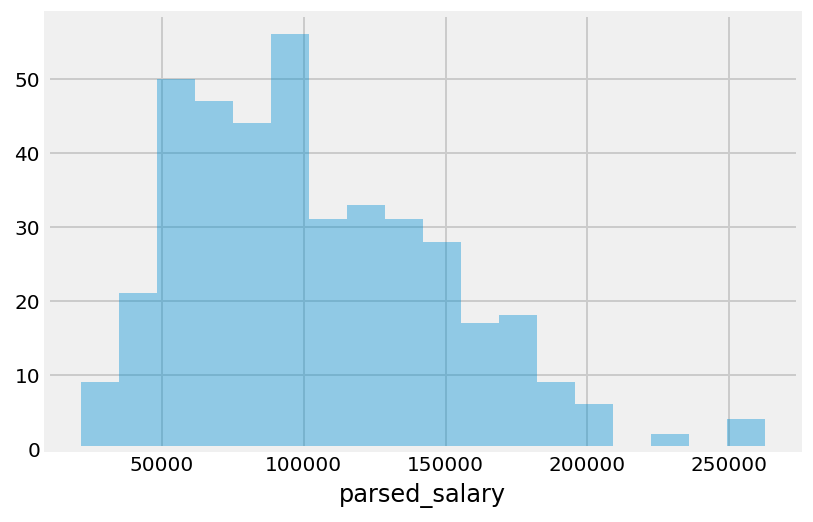

In [45]:
# Distribution appears to be postively skewed.
sns.distplot(salary_data['parsed_salary'], bins=18, kde=False)
plt.show()

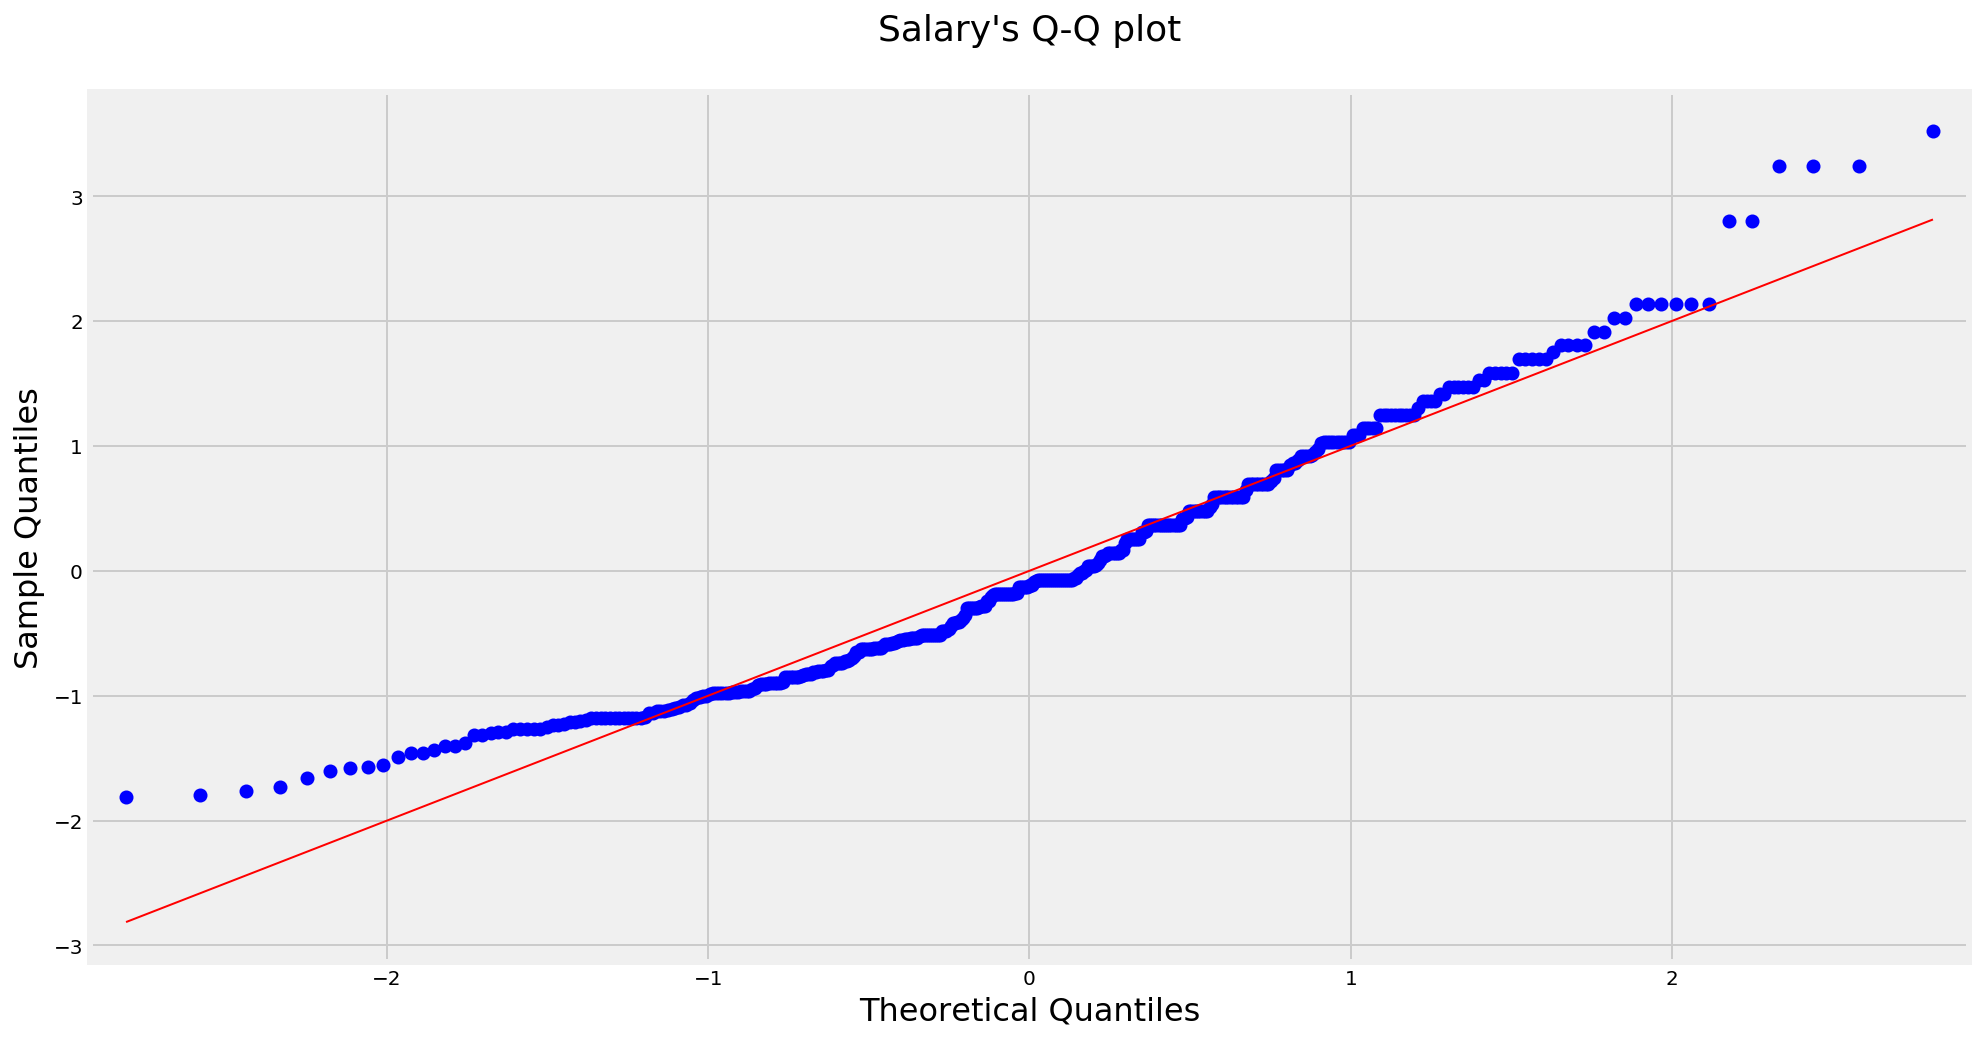

In [46]:
# a normal distribution seems to be a poor approximation for the values on the extremities of the distribution.
# since we intend to use the median of the salary as the main metric, the model shouldn't be too impacted by that.
fig = plt.figure(figsize=(15, 8))
ax = plt.gca()
qqplot(np.array(salary_data['parsed_salary']), line='s', fit=True, ax=ax)
plt.xlabel('Theoretical Quantiles', fontsize=16)
plt.ylabel('Sample Quantiles', fontsize=16)
ax.set_title("Salary's Q-Q plot\n", fontsize=18)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [47]:
# Investigate the median salary / city
salary_data.groupby('city')[['parsed_salary']].median().sort_values(
    by='parsed_salary', ascending=False).head(10)

,parsed_salary
city,
Redwood City,180000.0
Mountain View,175000.0
Santa Clara,172500.0
San Jose,170000.0
El Segundo,162500.0
San Francisco,162500.0
Sunnyvale,155000.0
Basking Ridge,152500.0
Aliso Viejo,150000.0


In [48]:
# there are no zero or negative salaries
salary_data[['parsed_salary']].describe()

,parsed_salary
count,406.000000
mean,103427.071429
std,45272.856592
min,21500.000000
25%,66879.500000
50%,98238.750000
75%,131875.000000
max,262500.000000


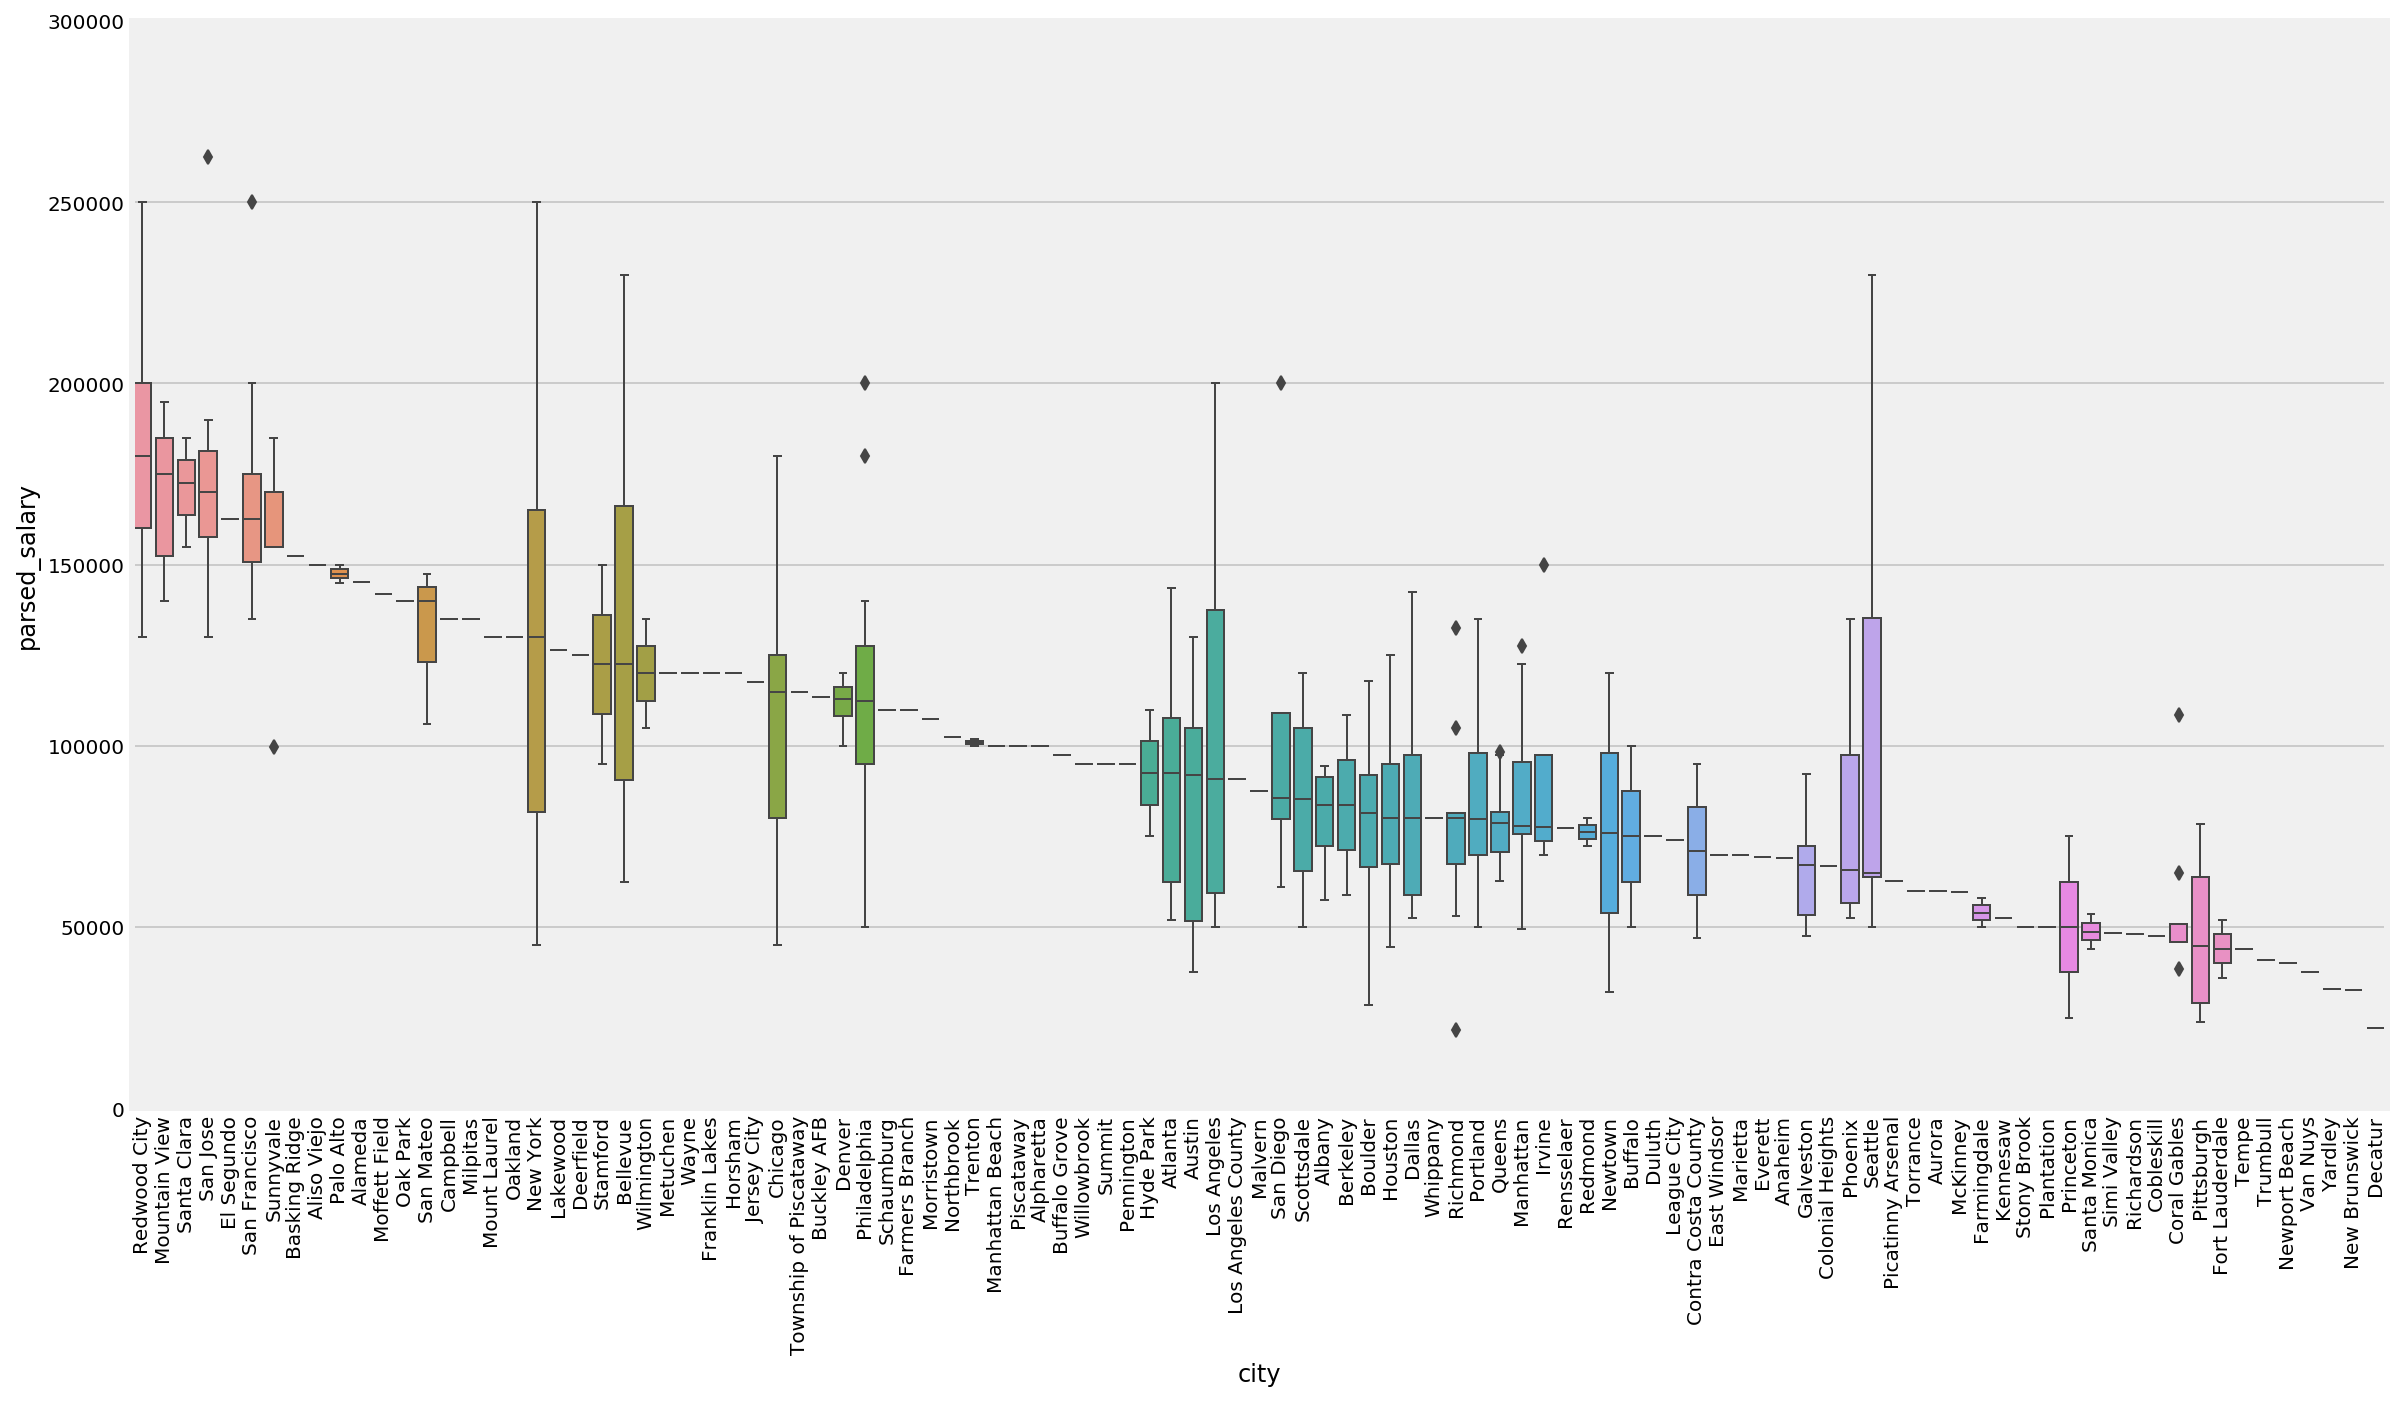

In [49]:
# boxplot of salaries / city
plt.figure(figsize=(15, 18))
order = salary_data.groupby(
    ['city'])['parsed_salary'].median().sort_values(ascending=False)
f, ax = plt.subplots(figsize=(18, 10))
f = sns.boxplot(x='city', y='parsed_salary',
                data=salary_data, order=order.index)
f.axis(ymin=0, ymax=300000)
plt.xticks(rotation=90)
plt.show()

In [50]:
# December 2017 a bug in statsmodel requires the following for the summary to work. Should be fixed soon.
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [51]:


med_ = np.median(salary_data.parsed_salary)

salary_data['HighSalary'] = salary_data.parsed_salary.map(lambda x: 1 if x > med_ else 0)


In [52]:
# Fit the model using the maximum likelihood function and statsmodel
import statsmodels.formula.api as sm

# Statsmodel formula adds in an intercept term
# also it automatically recognise the feature as categorical

model = sm.logit("HighSalary ~ C(city, Treatment(reference='Houston'))",
                 data=salary_data).fit(method='ncg')
# model_state = sm.logit("HighSalary ~ C(state, Treatment(reference='AZ'))", data=salary_data).fit(method='ncg')

# Remember statsmodel does not use regularisation by default, ‘ncg’ is for Newton-conjugate gradient as the solver
# Otherwise we have some multicolinerity issues
model.summary()

Optimization terminated successfully.
         Current function value: 0.381254
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 28
         Hessian evaluations: 14


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             HighSalary   No. Observations:                  406
Model:                          Logit   Df Residuals:                      303
Method:                           MLE   Df Model:                          102
Date:                Fri, 04 May 2018   Pseudo R-squ.:                  0.4500
Time:                        14:12:23   Log-Likelihood:                -154.79
converged:                       True   LL-Null:                       -281.42
                                        LLR p-value:                 7.312e-15
=====================================================================================================================================
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.9808      0.677     -1.449      0.147      -2.308       0.346
C(city, Treatment(reference='Houston'))[T.Alameda]                   12.7258    355.132      0.036      0.971    -683.321     708.772
C(city, Treatment(reference='Houston'))[T.Albany]                   -12.1504    355.122     -0.034      0.973    -708.176     683.876
C(city, Treatment(reference='Houston'))[T.Aliso Viejo]               12.7258    355.132      0.036      0.971    -683.321     708.772
C(city, Treatment(reference='Houston'))[T.Alpharetta]                12.7258    355.132      0.036      0.971    -683.321     708.772
C(city, Treatment(reference='Houston'))[T.Anaheim]                  -10.7641    355.121     -0.030      0.976    -706.789     685.260
C(city, Treatment(reference='Houston'))[T.Atlanta]                    0.5390      0.801      0.673      0.501      -1.030       2.108
C(city, Treatment(reference='Houston'))[T.Aurora]                   -10.7641    355.121     -0.030      0.976    -706.789     685.260
C(city, Treatment(reference='Houston'))[T.Austin]                     0.4700      0.996      0.472      0.637      -1.482       2.422
C(city, Treatment(reference='Houston'))[T.Basking Ridge]             12.7258    355.132      0.036      0.971    -683.321     708.772
C(city, Treatment(reference='Houston'))[T.Bellevue]                   2.0794      1.339      1.554      0.120      -0.544       4.703
C(city, Treatment(reference='Houston'))[T.Berkeley]                   0.9808      1.568      0.626      0.532      -2.092       4.054
C(city, Treatment(reference='Houston'))[T.Boulder]                   -0.1178      1.339     -0.088      0.930      -2.741       2.506
C(city, Treatment(reference='Houston'))[T.Buckley AFB]               12.7258    355.132      0.036      0.971    -683.321     708.772
C(city, Treatment(reference='Houston'))[T.Buffalo]                    0.9808      1.568      0.626      0.532      -2.092       4.054
C(city, Treatment(reference='Houston'))[T.Buffalo Grove]            -10.7641    355.121     -0.030      0.976    -706.789     685.260
C(city, Treatment(reference='Houston'))[T.Campbell]                  12.7258    355.132      0.036      0.971    -683.321     708.772
C(city, Treatment(reference='Houston'))[T.Chicago]                    1.4773      0.757      1.951      0.051      -0.007       2.961
C(city, Treatment(reference='Houston'))[T.Cobleskill]               -10.7641    355.121     -0.030      0.976    -706.789     685.260
C(city, Treatment(reference='Houston'))[T.Colonial Heights]         -11.4572    355.122     -0.032      0.974    -707.483     684.568
C(city, Treatment(reference='Houston'))[T.Contra Costa County]      -11.4572    355.122     -0.032      0.974    -707.483     684.568
C(city, Treatment(referen

In [53]:
# Reference category is set to be Houston. This is wrapped into the intercept term.
# The other categories must be interpreted as significantly different from Houston or not.

# Significantly different ( P>|z| less than 0.05):
# New York
# Philadelphia


# The rest of the categories are not significantly different than the Houston category
# in their probability of being 0 or 1 for salary.

In [54]:
Xpredict = salary_data.loc[:, ['city']]

In [55]:
y_prob = model.predict(Xpredict)
y_pred = 1 * (y_prob > 0.5).values
print('Logistic Regression Predicted Classes:', y_pred)

Logistic Regression Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0
 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1]


In [56]:
# Compare predictions to real y values.
y = salary_data.loc[:, 'HighSalary']
print('Accuracy score:', accuracy_score(y, y_pred))
# 72% correctly classified so the model is doing OK... False negatives approx. equal to false postives.
print('Confusion matrix:', confusion_matrix(y, y_pred))

Accuracy score: 0.7931034482758621
Confusion matrix: [[172  31]
 [ 53 150]]


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title. 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [57]:
senior = ['Senior', 'Sr', 'Sr.']
salary_data['Senior'] = [
    1 if any(word in x for word in senior) else 0 for x in salary_data.position]
salary_data['Manager'] = [
    1 if 'Manager' in x else 0 for x in salary_data.position]
salary_data['Junior'] = [
    1 if 'Junior' in x else 0 for x in salary_data.position]
salary_data['Research'] = [
    1 if 'Research' in x else 0 for x in salary_data.position]
salary_data['Environment'] = [
    1 if 'Environment' in x else 0 for x in salary_data.position]
salary_data['Principal'] = [
    1 if 'Principal' in x else 0 for x in salary_data.position]
salary_data['Assistant'] = [
    1 if 'Assistant' in x else 0 for x in salary_data.position]

In [58]:
model = sm.logit("HighSalary ~ C(city, Treatment(reference='Houston')) + Senior + Junior + Manager + Research + Environment + Principal + Assistant",
                 data=salary_data).fit(method='ncg')
model.summary()

Optimization terminated successfully.
         Current function value: 0.297298
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 32
         Hessian evaluations: 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             HighSalary   No. Observations:                  406
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                          109
Date:                Fri, 04 May 2018   Pseudo R-squ.:                  0.5711
Time:                        14:13:37   Log-Likelihood:                -120.70
converged:                       True   LL-Null:                       -281.42
                                        LLR p-value:                 8.019e-23
=====================================================================================================================================
                                                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            -0.5786      0.715     -0.809      0.418      -1.980       0.823
C(city, Treatment(reference='Houston'))[T.Alameda]                   12.6506    418.221      0.030      0.976    -807.047     832.348
C(city, Treatment(reference='Houston'))[T.Albany]                    -9.6240    418.759     -0.023      0.982    -830.377     811.128
C(city, Treatment(reference='Houston'))[T.Aliso Viejo]               12.6506    418.221      0.030      0.976    -807.047     832.348
C(city, Treatment(reference='Houston'))[T.Alpharetta]                12.6506    418.221      0.030      0.976    -807.047     832.348
C(city, Treatment(reference='Houston'))[T.Anaheim]                  -12.3626    418.592     -0.030      0.976    -832.789     808.063
C(city, Treatment(reference='Houston'))[T.Atlanta]                    0.6015      0.876      0.687      0.492      -1.115       2.318
C(city, Treatment(reference='Houston'))[T.Aurora]                   -11.4951    418.564     -0.027      0.978    -831.866     808.876
C(city, Treatment(reference='Houston'))[T.Austin]                     0.3836      1.079      0.356      0.722      -1.730       2.498
C(city, Treatment(reference='Houston'))[T.Basking Ridge]             11.7834    418.274      0.028      0.978    -808.019     831.586
C(city, Treatment(reference='Houston'))[T.Bellevue]                  12.8967    304.029      0.042      0.966    -582.989     608.782
C(city, Treatment(reference='Houston'))[T.Berkeley]                  12.0902    306.823      0.039      0.969    -589.272     613.452
C(city, Treatment(reference='Houston'))[T.Boulder]                   -0.5201      1.358     -0.383      0.702      -3.182       2.142
C(city, Treatment(reference='Houston'))[T.Buckley AFB]               15.6189    417.745      0.037      0.970    -803.146     834.384
C(city, Treatment(reference='Houston'))[T.Buffalo]                    2.0639      1.978      1.043      0.297      -1.813       5.941
C(city, Treatment(reference='Houston'))[T.Buffalo Grove]            -12.3626    418.592     -0.030      0.976    -832.789     808.063
C(city, Treatment(reference='Houston'))[T.Campbell]                  11.7557    418.357      0.028      0.978    -808.209     831.720
C(city, Treatment(reference='Houston'))[T.Chicago]                    1.1478      0.802      1.431      0.153      -0.425       2.720
C(city, Treatment(reference='Houston'))[T.Cobleskill]                -8.5258    418.842     -0.020      0.984    -829.441     812.390
C(city, Treatment(reference='Houston'))[T.Colonial Heights]          -1.2423   1.15e+05  -1.08e-05      1.000   -2.25e+05    2.25e+05
C(city, Treatment(reference='Houston'))[T.Contra Costa County]      -12.1884    418.599     -0.029      0.977    -832.628     808.251
C(city, Treatment(referen

In [ ]:
# Manager and Research have p values less than 0.05.

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`.
- Remember to scale the feature variables as well!


In [59]:
salary_data.columns.values

array(['position', 'company', 'salary', 'summary', 'parsed_salary',
       'HighSalary', 'city', 'state', 'Senior', 'Manager', 'Junior',
       'Research', 'Environment', 'Principal', 'Assistant'], dtype=object)

In [60]:
X = salary_data.loc[:, ['city', 'Senior', 'Manager', 'Junior',
                        'Research', 'Environment', 'Principal', 'Assistant']]
X = pd.get_dummies(X, drop_first=True)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

from sklearn.model_selection import train_test_split
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(284, 109) (284,)
(122, 109) (122,)


In [61]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=.5, solver='newton-cg')
# Uses regularisation by default, setting C to be high, makes effect disappear.

lr.fit(X_train, y_train)
# print 'Intercept:', lr.intercept_
# print 'Coefficents:', lr.coef_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [63]:
from sklearn.model_selection import cross_val_score

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(lr, X, y, cv=5, scoring=metric)
    print((metric, scores.mean(), scores.std()))

('accuracy', 0.677439024390244, 0.030055471222169745)
('precision', 0.6416779264495419, 0.04812625645676325)
('recall', 0.8478048780487804, 0.14089171695737865)
('roc_auc', 0.7596872025580013, 0.05928533829150354)


In [64]:
# cross validate the model
# taking into account the baseline accuracy of 0.5, the model is performing quite well, but there still is room for a
# lot of improvement
print('Cross validation score:\t{:.4f}'.format(cross_val_score(lr, X_train, y_train, cv=5).mean()))
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
y_pp_1 = lr.predict_proba(X_test)[:, 1]

print("Model with l2 penalty accuracy:\t\t{:.4f}".format(accuracy_score(y_test, yhat)))
print("Model with l2 penalty ROC AUC:\t\t{:.4f}\n".format(roc_auc_score(y_test, y_pp_1)))
print(classification_report(y_test, yhat))

Cross validation score:	0.7361
Model with l2 penalty accuracy:		0.7705
Model with l2 penalty ROC AUC:		0.8589

             precision    recall  f1-score   support

          0       0.75      0.72      0.73        53
          1       0.79      0.81      0.80        69

avg / total       0.77      0.77      0.77       122



#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [65]:
model = LogisticRegression(penalty='l1', C=5.0)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, cv=5, scoring=metric)
    print((metric, scores.mean(), scores.std()))


print()
model = LogisticRegression(penalty='l1', C=0.1)

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, cv=5, scoring=metric)
    print((metric, scores.mean(), scores.std()))

print()
model = LogisticRegression(penalty='l2', C=.5, solver='newton-cg')

for metric in ['accuracy', 'precision', 'recall', 'roc_auc']:
    scores = cross_val_score(model, X, y, cv=5, scoring=metric)
    print((metric, scores.mean(), scores.std()))

('accuracy', 0.6677439024390244, 0.034903623575883176)
('precision', 0.6210116764096943, 0.023722171087756042)
('recall', 0.8671951219512195, 0.10000029744155645)
('roc_auc', 0.7410913890541344, 0.06600706385561146)

('accuracy', 0.6184146341463415, 0.019535618562600936)
('precision', 0.6930812471110979, 0.14226292567575963)
('recall', 0.6728048780487804, 0.3603557631371738)
('roc_auc', 0.7020506395002974, 0.017233016527659045)

('accuracy', 0.677439024390244, 0.030055471222169745)
('precision', 0.6416779264495419, 0.04812625645676325)
('recall', 0.8478048780487804, 0.14089171695737865)
('roc_auc', 0.7596872025580013, 0.05928533829150354)


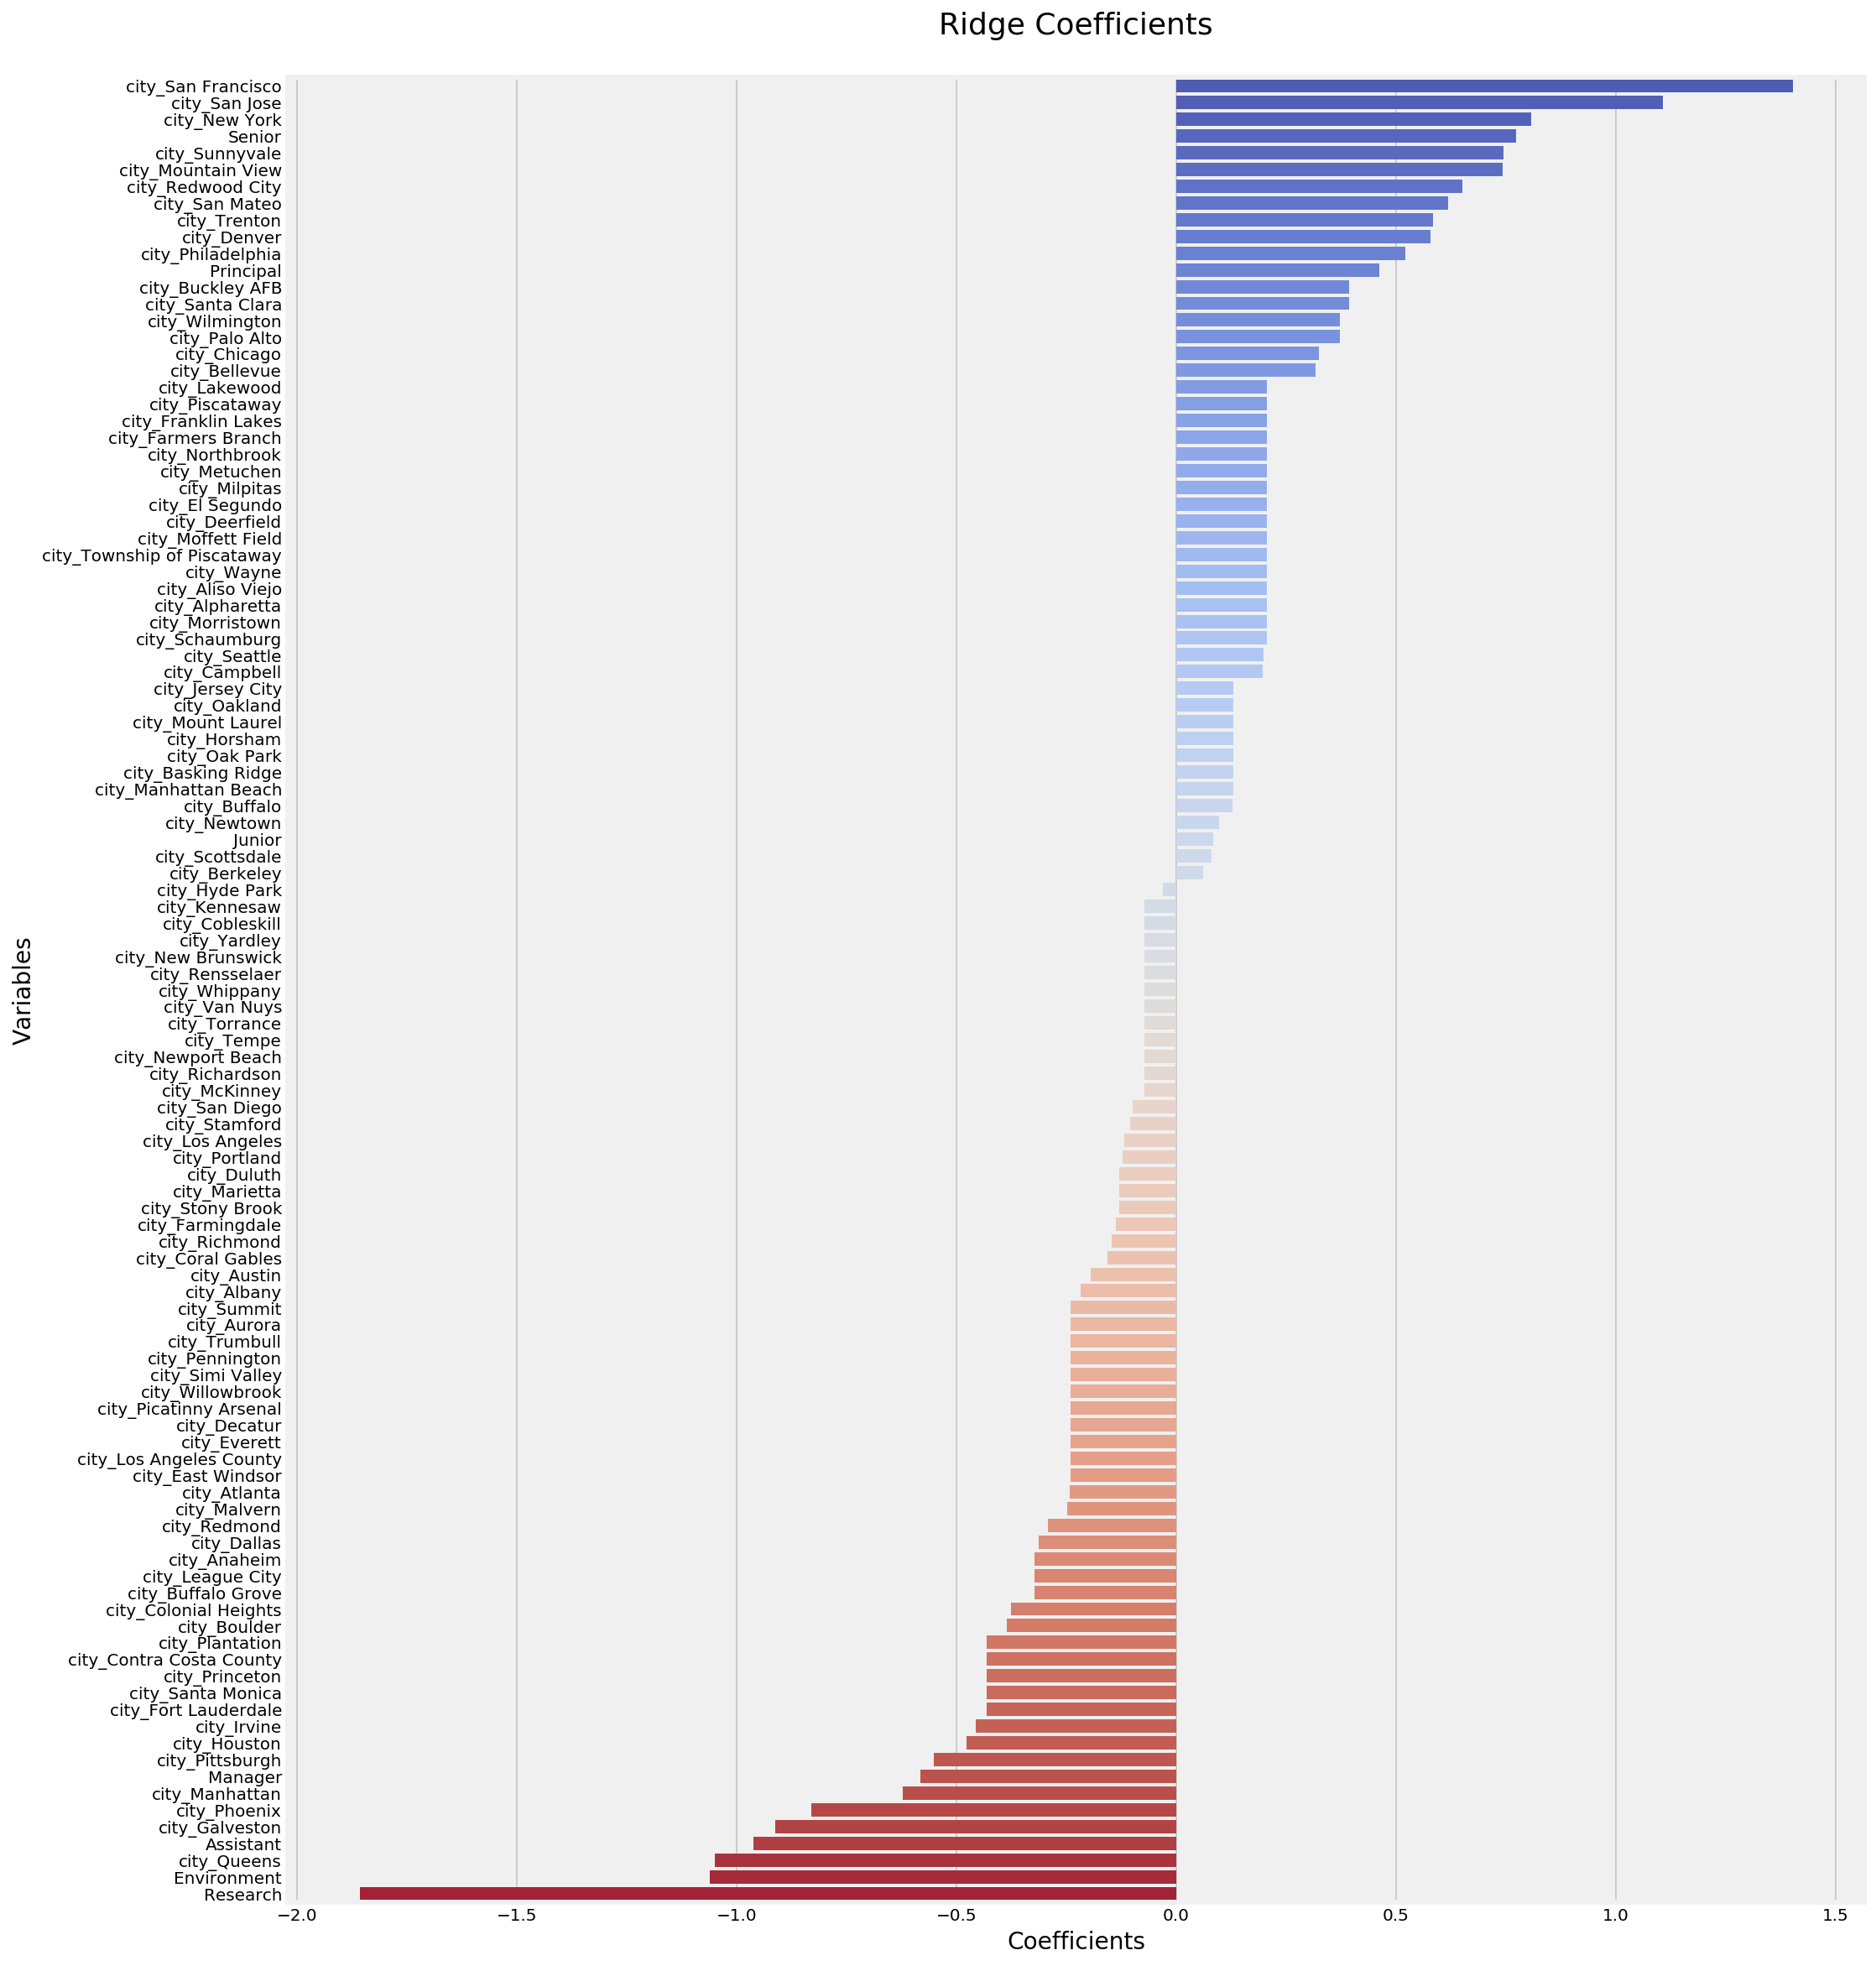

In [69]:
# soem coefficients were really supressed
# create a series with the coefficients of the lasso regression and the variables names
model.fit(X,y)
coefs = pd.Series(data=model.coef_[0], index=X.columns)

# sort the series
coefs = coefs.sort_values(ascending=False)

# create a barplot
plt.figure(figsize=(15, 20))
plt.title('Ridge Coefficients\n', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Variables', fontsize=14)
sns.barplot(y=coefs.index, x=coefs.values, orient='h', palette='coolwarm')
plt.show()

In [70]:
model.fit(X, y)

df = pd.DataFrame({'features': X.columns,
                   'coef': model.coef_[0, :]})
df.sort_values('coef', ascending=False, inplace=True)
df.head()

,coef,features
85,1.402249,city_San Francisco
86,1.107389,city_San Jose
62,0.806340,city_New York
0,0.772752,Senior
97,0.743289,city_Sunnyvale


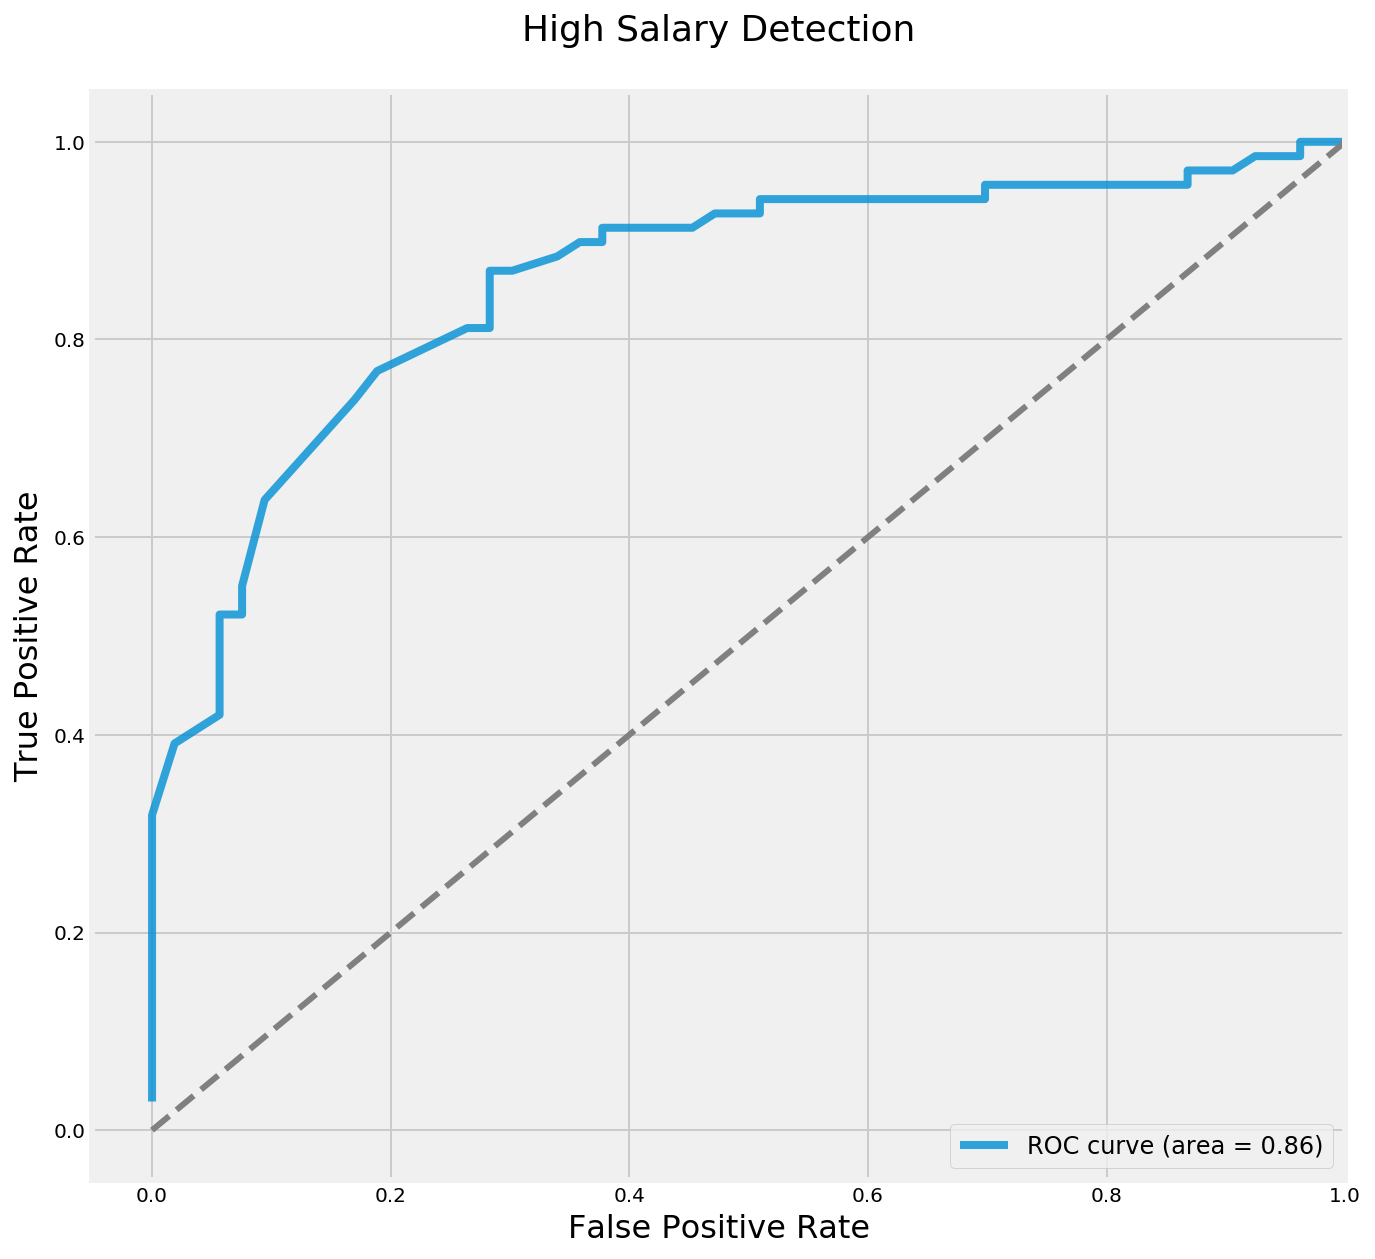

In [71]:
# ROC curve suggests that a lower threshold might benefit the overall performance of the model,
# given that there is
# a sudden increase in the True Positive Rate in the right side of the chart
fpr, tpr, threshold = roc_curve(y_test, y_pp_1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[10, 10])
plt.plot(fpr, tpr, label='ROC curve (area = {:0.2f})'.format(
    roc_auc), lw=4, alpha=.8)
plt.plot([0, 1], [0, 1], ls='--', c='grey', linewidth=3)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('High Salary Detection\n', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.show()

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients.

In [72]:
salary_data.head(3)

,position,company,salary,summary,parsed_salary,HighSalary,city,state,Senior,Manager,Junior,Research,Environment,Principal,Assistant
0,Epidemiologist,Centers for Disease Control and Prevention,"$77,058 - $119,121 a year","Data Management, Analysis, and Interpretation....",98089.5,0,Atlanta,GA,0,0,0,0,0,0,0
1,Economist,Centers for Disease Control and Prevention,"$91,631 - $119,121 a year",Specialized experience is experience which is ...,105376.0,1,Atlanta,GA,0,0,0,0,0,0,0
2,"Junior Data Analyst (R, Excel, SQL)",Jobspring Partners,"$60,000 - $80,000 a year",A reinsurance company that leverages technolog...,70000.0,0,Irvine,CA,0,0,1,0,0,0,0


In [73]:
# use count vectorizer to assess the most used words in companies
cv = CountVectorizer(max_features=30, stop_words='english',
                     ngram_range=(1, 2), binary=True)
pd.DataFrame(cv.fit_transform(salary_data['company']).sum(
    axis=0).reshape(-1, 1), index=cv.get_feature_names(), columns=['count']).sort_values('count', ascending=False)

,count
university,43
associates,41
partners,39
jobspring partners,39
jobspring,39
health,36
workbridge,32
workbridge associates,32
dept,30
department,25


In [74]:
# create a dictionary of terms and their corresponding industry segment
industry = [('university', 'education'), ('health', 'health care'), ('dept', 'governamental'),
            ('technology', 'it'), ('cancer', 'health care')]

# create a new column containing the respective industry segments
salary_data['industry'] = 'other'
for key, ind in industry:
    temp_mask = salary_data['company'].str.lower().str.contains(key)
    salary_data.loc[temp_mask, 'industry'] = ind

salary_data['industry'].value_counts()

other            309
education         39
governamental     30
health care       19
it                 9
Name: industry, dtype: int64

In [75]:
X = salary_data.loc[:, ['city', 'Senior', 'Manager', 'Junior',
                        'Research', 'Environment', 'Principal', 'Assistant', 'industry']]

In [76]:
X = pd.get_dummies(X, columns=['city', 'industry'])

In [77]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

from sklearn.model_selection import train_test_split
np.random.seed(1234)
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(284, 115) (284,)
(122, 115) (122,)


In [78]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2', C=.5, solver='newton-cg')
# Uses regularisation by default, setting C to be high, makes effect disappear.

lr.fit(X_train, y_train)
# print 'Intercept:', lr.intercept_
# print 'Coefficents:', lr.coef_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
# cross validate the model
# taking into account the baseline accuracy of 0.5, the model is performing quite well, but there still is room for a
# lot of improvement
print('Cross validation score:\t{:.4f}'.format(cross_val_score(lr, X_train, y_train, cv=5).mean()))
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
y_pp_1 = lr.predict_proba(X_test)[:, 1]

print("Model with l2 penalty accuracy:\t\t{:.4f}".format(accuracy_score(y_test, yhat)))
print("Model with l2 penalty ROC AUC:\t\t{:.4f}\n".format(roc_auc_score(y_test, y_pp_1)))
print(classification_report(y_test, yhat))

Cross validation score:	0.7465
Model with l2 penalty accuracy:		0.7951
Model with l2 penalty ROC AUC:		0.8709

             precision    recall  f1-score   support

          0       0.78      0.74      0.76        53
          1       0.81      0.84      0.82        69

avg / total       0.79      0.80      0.79       122



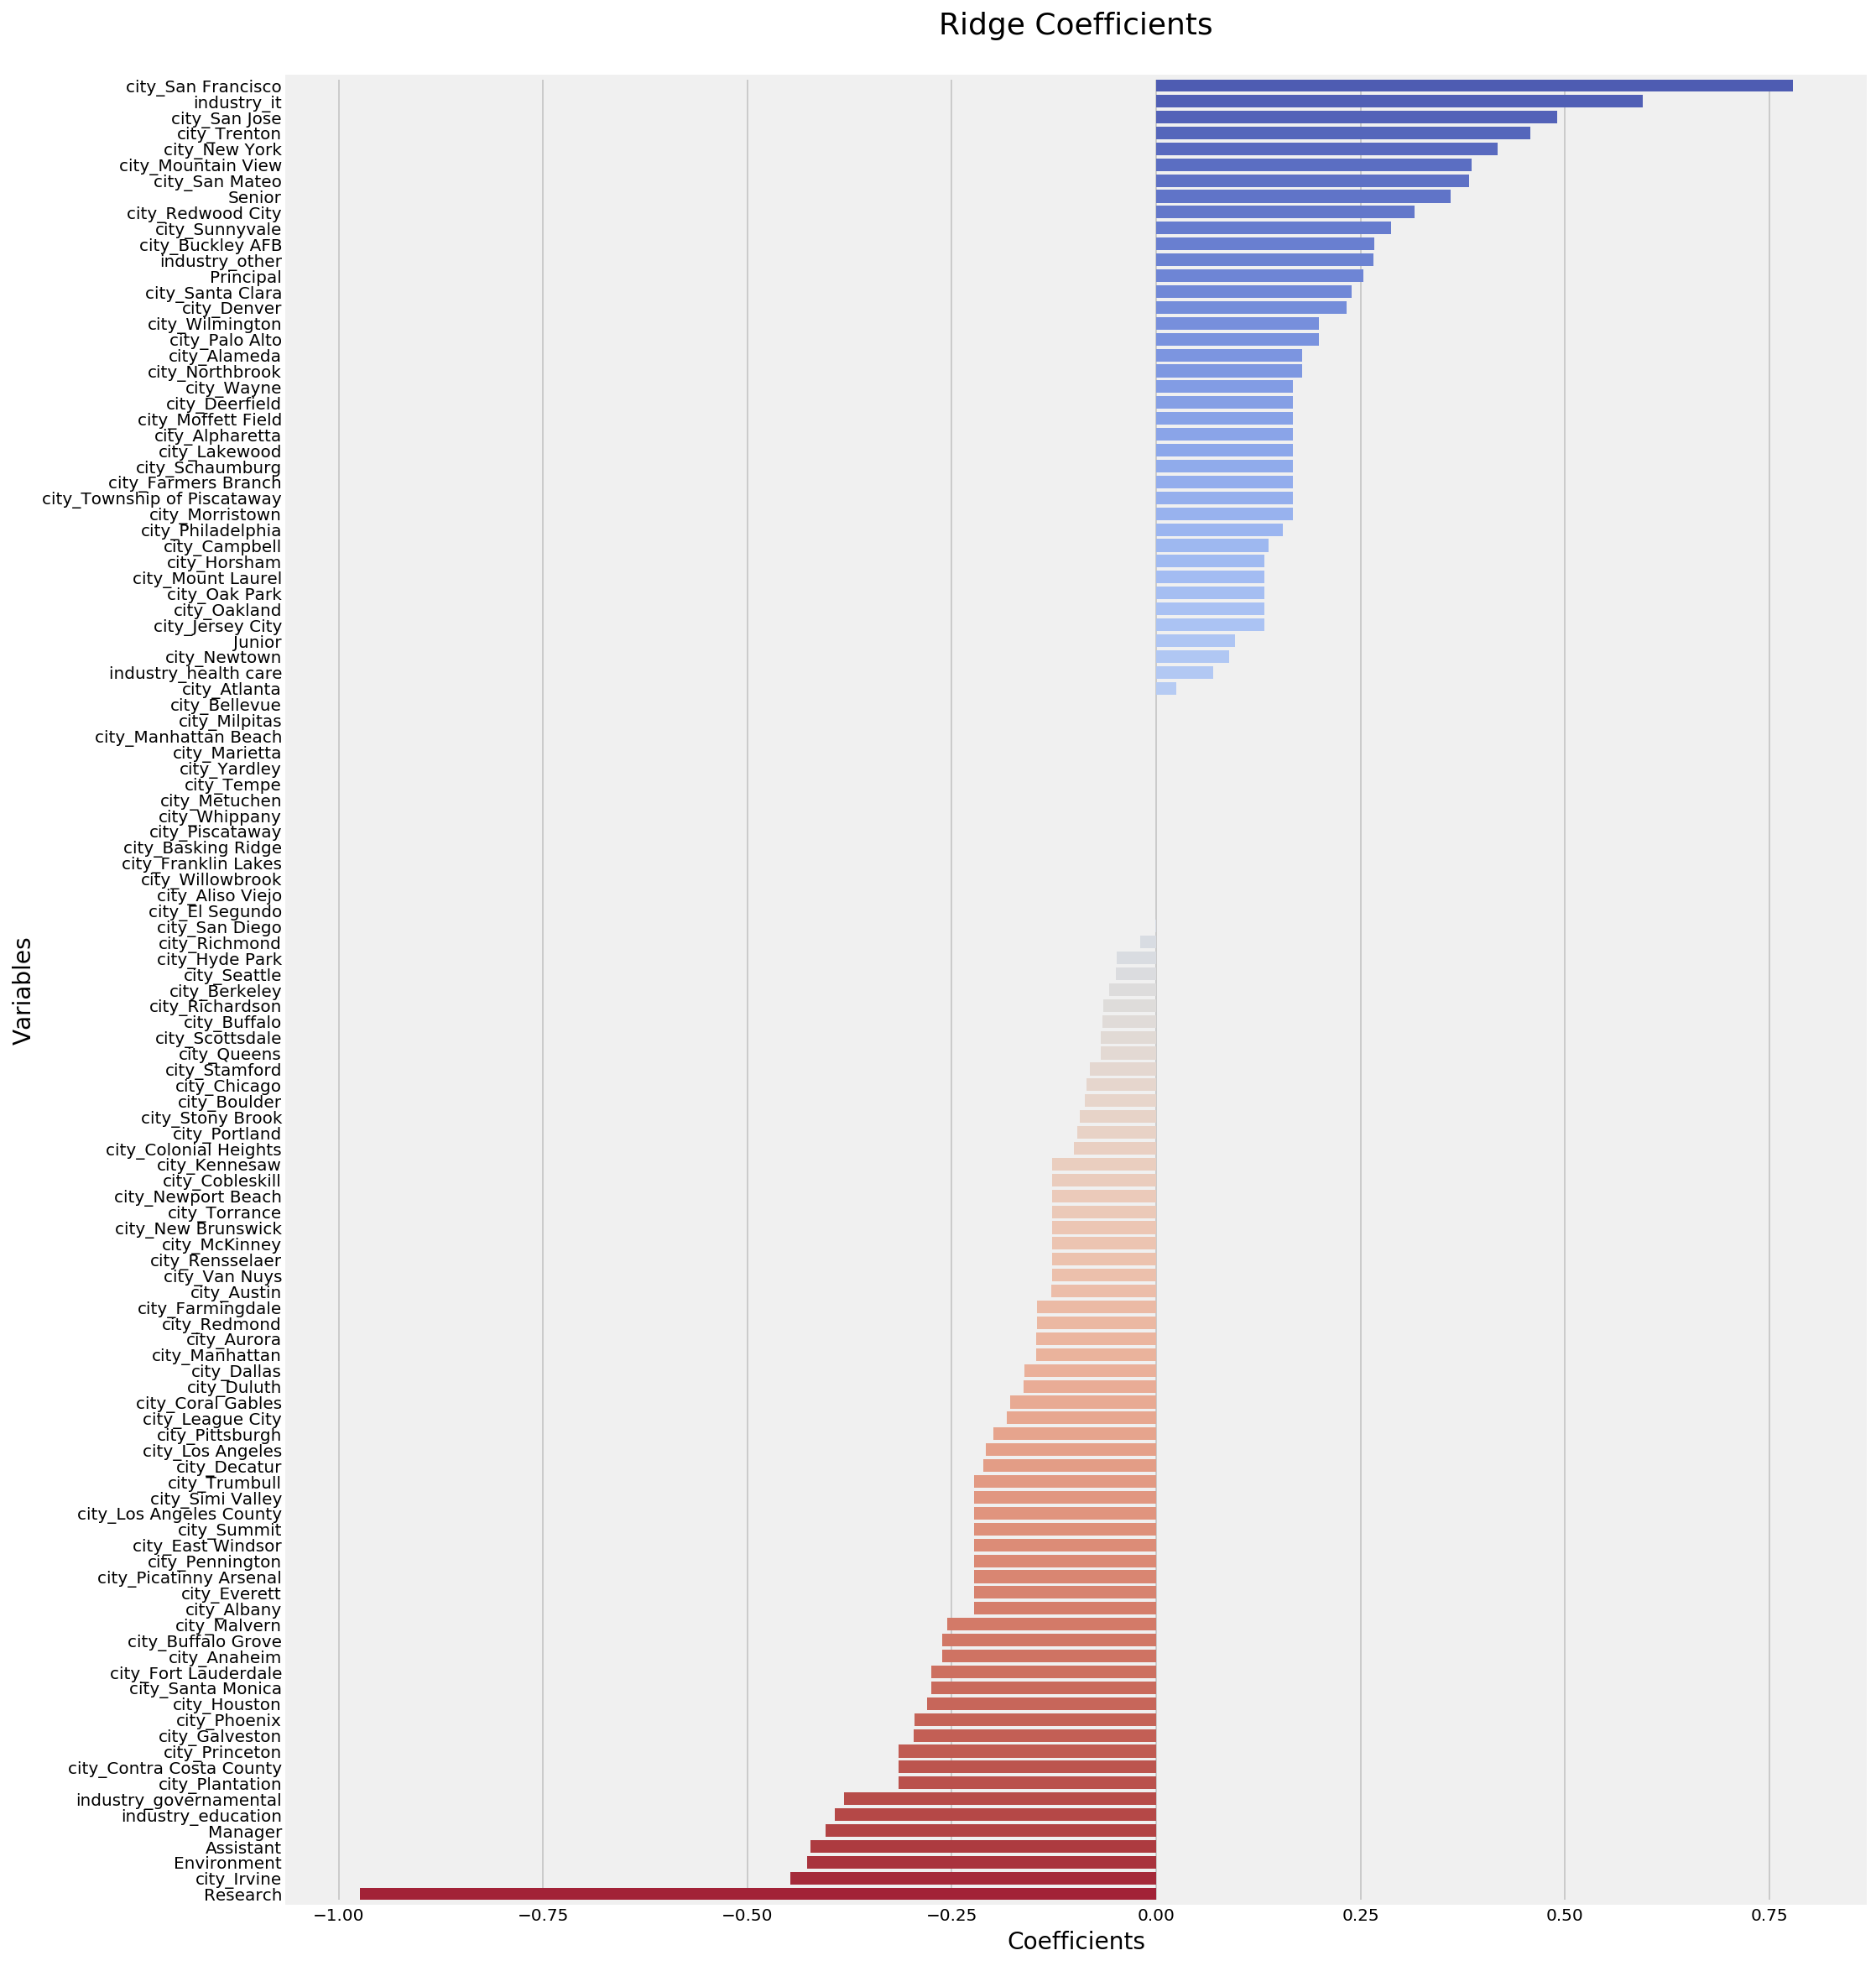

In [80]:
# soem coefficients were really supressed
# create a series with the coefficients of the lasso regression and the variables names
coefs = pd.Series(data=lr.coef_[0], index=X.columns)

# sort the series
coefs = coefs.sort_values(ascending=False)

# create a barplot
plt.figure(figsize=(15, 20))
plt.title('Ridge Coefficients\n', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Variables', fontsize=14)
sns.barplot(y=coefs.index, x=coefs.values, orient='h', palette='coolwarm')
plt.show()

In [81]:
# Gridsearch
# find the best alpha for a linear regression with Ridge regularization
alphas = np.logspace(-5, 5, 1000)
# Lets set our model parameters
logreg_cv = LogisticRegressionCV(
    Cs=alphas, cv=5, penalty='l2', scoring='accuracy', solver='newton-cg')
logreg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.00000e-05, 1.02332e-05, ..., 9.77215e+04, 1.00000e+05]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring='accuracy', solver='newton-cg', tol=0.0001, verbose=0)

In [82]:
logreg_cv.C_[0]

0.02712897800372467

In [83]:
lr = LogisticRegression(penalty='l2', C=logreg_cv.C_[0], solver='newton-cg')
# Uses regularisation by default, setting C to be high, makes effect disappear.

lr.fit(X_train, y_train)
# print 'Intercept:', lr.intercept_
# print 'Coefficents:', lr.coef_

LogisticRegression(C=0.02712897800372467, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [84]:
# cross validate the model
# taking into account the baseline accuracy of 0.5, the model is performing quite well, but there still is room for a
# lot of improvement
print('Cross validation score:\t{:.4f}'.format(cross_val_score(lr, X_train, y_train, cv=5).mean()))
lr.fit(X_train, y_train)
yhat = lr.predict(X_test)
y_pp_1 = lr.predict_proba(X_test)[:, 1]

print("Model with l2 penalty accuracy:\t\t{:.4f}".format(accuracy_score(y_test, yhat)))
print("Model with l2 penalty ROC AUC:\t\t{:.4f}\n".format(roc_auc_score(y_test, y_pp_1)))
print(classification_report(y_test, yhat))

Cross validation score:	0.7783
Model with l2 penalty accuracy:		0.7869
Model with l2 penalty ROC AUC:		0.8711

             precision    recall  f1-score   support

          0       0.75      0.77      0.76        53
          1       0.82      0.80      0.81        69

avg / total       0.79      0.79      0.79       122



#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

In [85]:
lr = LogisticRegression(penalty='l2', C=logreg_cv.C_[0], solver='newton-cg')
# Uses regularisation by default, setting C to be high, makes effect disappear.
# Fit on entire data set
lr.fit(X, y)

LogisticRegression(C=0.02712897800372467, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [86]:
mask = np.random.choice(len(salary_data), size=100, replace=False)

In [87]:
X_ = X.iloc[mask]
y_ = y.iloc[mask]

In [88]:
lr.score(X_, y_)

0.72

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model.
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are most valuable? 

In [89]:
# used Tfidf in order to penalize very common words
cv = TfidfVectorizer(encoding='latin', max_features=30,
                     binary=True, stop_words='english')

# stem the works in order to group together words with similar meanings
# stemmer = porter.PorterStemmer()
# stemmed = jobs['summary'].map(lambda x: ' '.join(
#     [stemmer.stem(word.decode('latin')) for word in re.findall(r'(?u)\b\w+\b', x)]))

# create a dataframe containing words as columns and word count for each entry
words_summary = pd.DataFrame(cv.fit_transform(salary_data.loc[X.index, 'summary']).toarray(), columns=cv.get_feature_names(), index=X.index)
words_summary.head()

,analysis,analyst,analytics,analyze,big,client,collection,company,data,experience,including,interpret,join,lead,learning,looking,machine,research,role,science,scientist,scientists,senior,skills,software,statistical,team,work,working,years
0,0.686643,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.277285,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.672037,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.572772,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.819715,0.0,0.0,0.000000,0.000000,0.0,0.0
2,0.401024,0.533296,0.0,0.0,0.0,0.0,0.0,0.49856,0.161945,0.000000,0.0,0.0,0.0,0.0,0.0,0.438604,0.0,0.0,0.0,0.0,0.295997,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.540087,0.0,0.000000,0.0,0.0,0.564322,0.624377,0.0,0.0
4,0.639750,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.258349,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.723861,0.0,0.0


In [90]:
# show the most relevant/recurrent words
words_summary.sum().sort_values(ascending=False)

data           106.932874
scientist       55.970670
scientists      39.845797
research        34.517378
analysis        34.495752
experience      32.601936
team            29.239270
looking         23.771745
work            23.535851
senior          19.550315
company         18.004257
science         17.671463
including       17.463827
statistical     16.981221
learning        16.876022
analytics       16.525250
collection      15.184883
analyst         14.633204
analyze         14.579647
machine         14.282868
role            14.218728
software        13.899654
client          13.788810
working         12.621141
skills          12.563244
years           11.986552
interpret       11.536847
big             11.318433
lead            11.113715
join            10.789727
dtype: float64

In [91]:
# adds the new features to the set of predictors
X_vec = pd.concat([X, words_summary], axis=1)
X_vec[:] = StandardScaler().fit_transform(X_vec)

# split the data
X_vec_train, X_vec_test, y_train, y_test = train_test_split(X_vec, y, test_size=.2, random_state=123)

In [92]:
# the extra features seem to have a negative impact of the performance of the model
# cross validate the model
print("Cross val:\t{:.4f}".format(cross_val_score(lr, X_vec_train, y_train, cv=10).mean()))

# fit and predict
lr.fit(X_vec_train, y_train)
yhat_vec = lr.predict(X_vec_test)
y_vec_pp_1 = lr.predict_proba(X_vec_test)[:,1]

print("Accuracy:\t{:.4f}".format(accuracy_score(y_test, yhat_vec)))
print("ROC AUC:\t{:.4f}\n".format(roc_auc_score(y_test, y_vec_pp_1)))
print(classification_report(y_test, yhat_vec))

Cross val:	0.7777
Accuracy:	0.8415
ROC AUC:	0.8819

             precision    recall  f1-score   support

          0       0.82      0.85      0.84        39
          1       0.86      0.84      0.85        43

avg / total       0.84      0.84      0.84        82



In [93]:
# create a series with the coefficients of the logistic regression
coefs = pd.Series(data=lr.coef_[0], index=X_vec.columns)
# sort the series
coefs = coefs.sort_values(ascending=False)

In [94]:
coefs.head()

city_San Francisco    0.245350
industry_it           0.239752
city_New York         0.220409
machine               0.189488
industry_other        0.171818
dtype: float64

In [95]:
coefs.tail()

city_Irvine          -0.139732
collection           -0.140287
industry_education   -0.214166
research             -0.218888
Research             -0.373068
dtype: float64

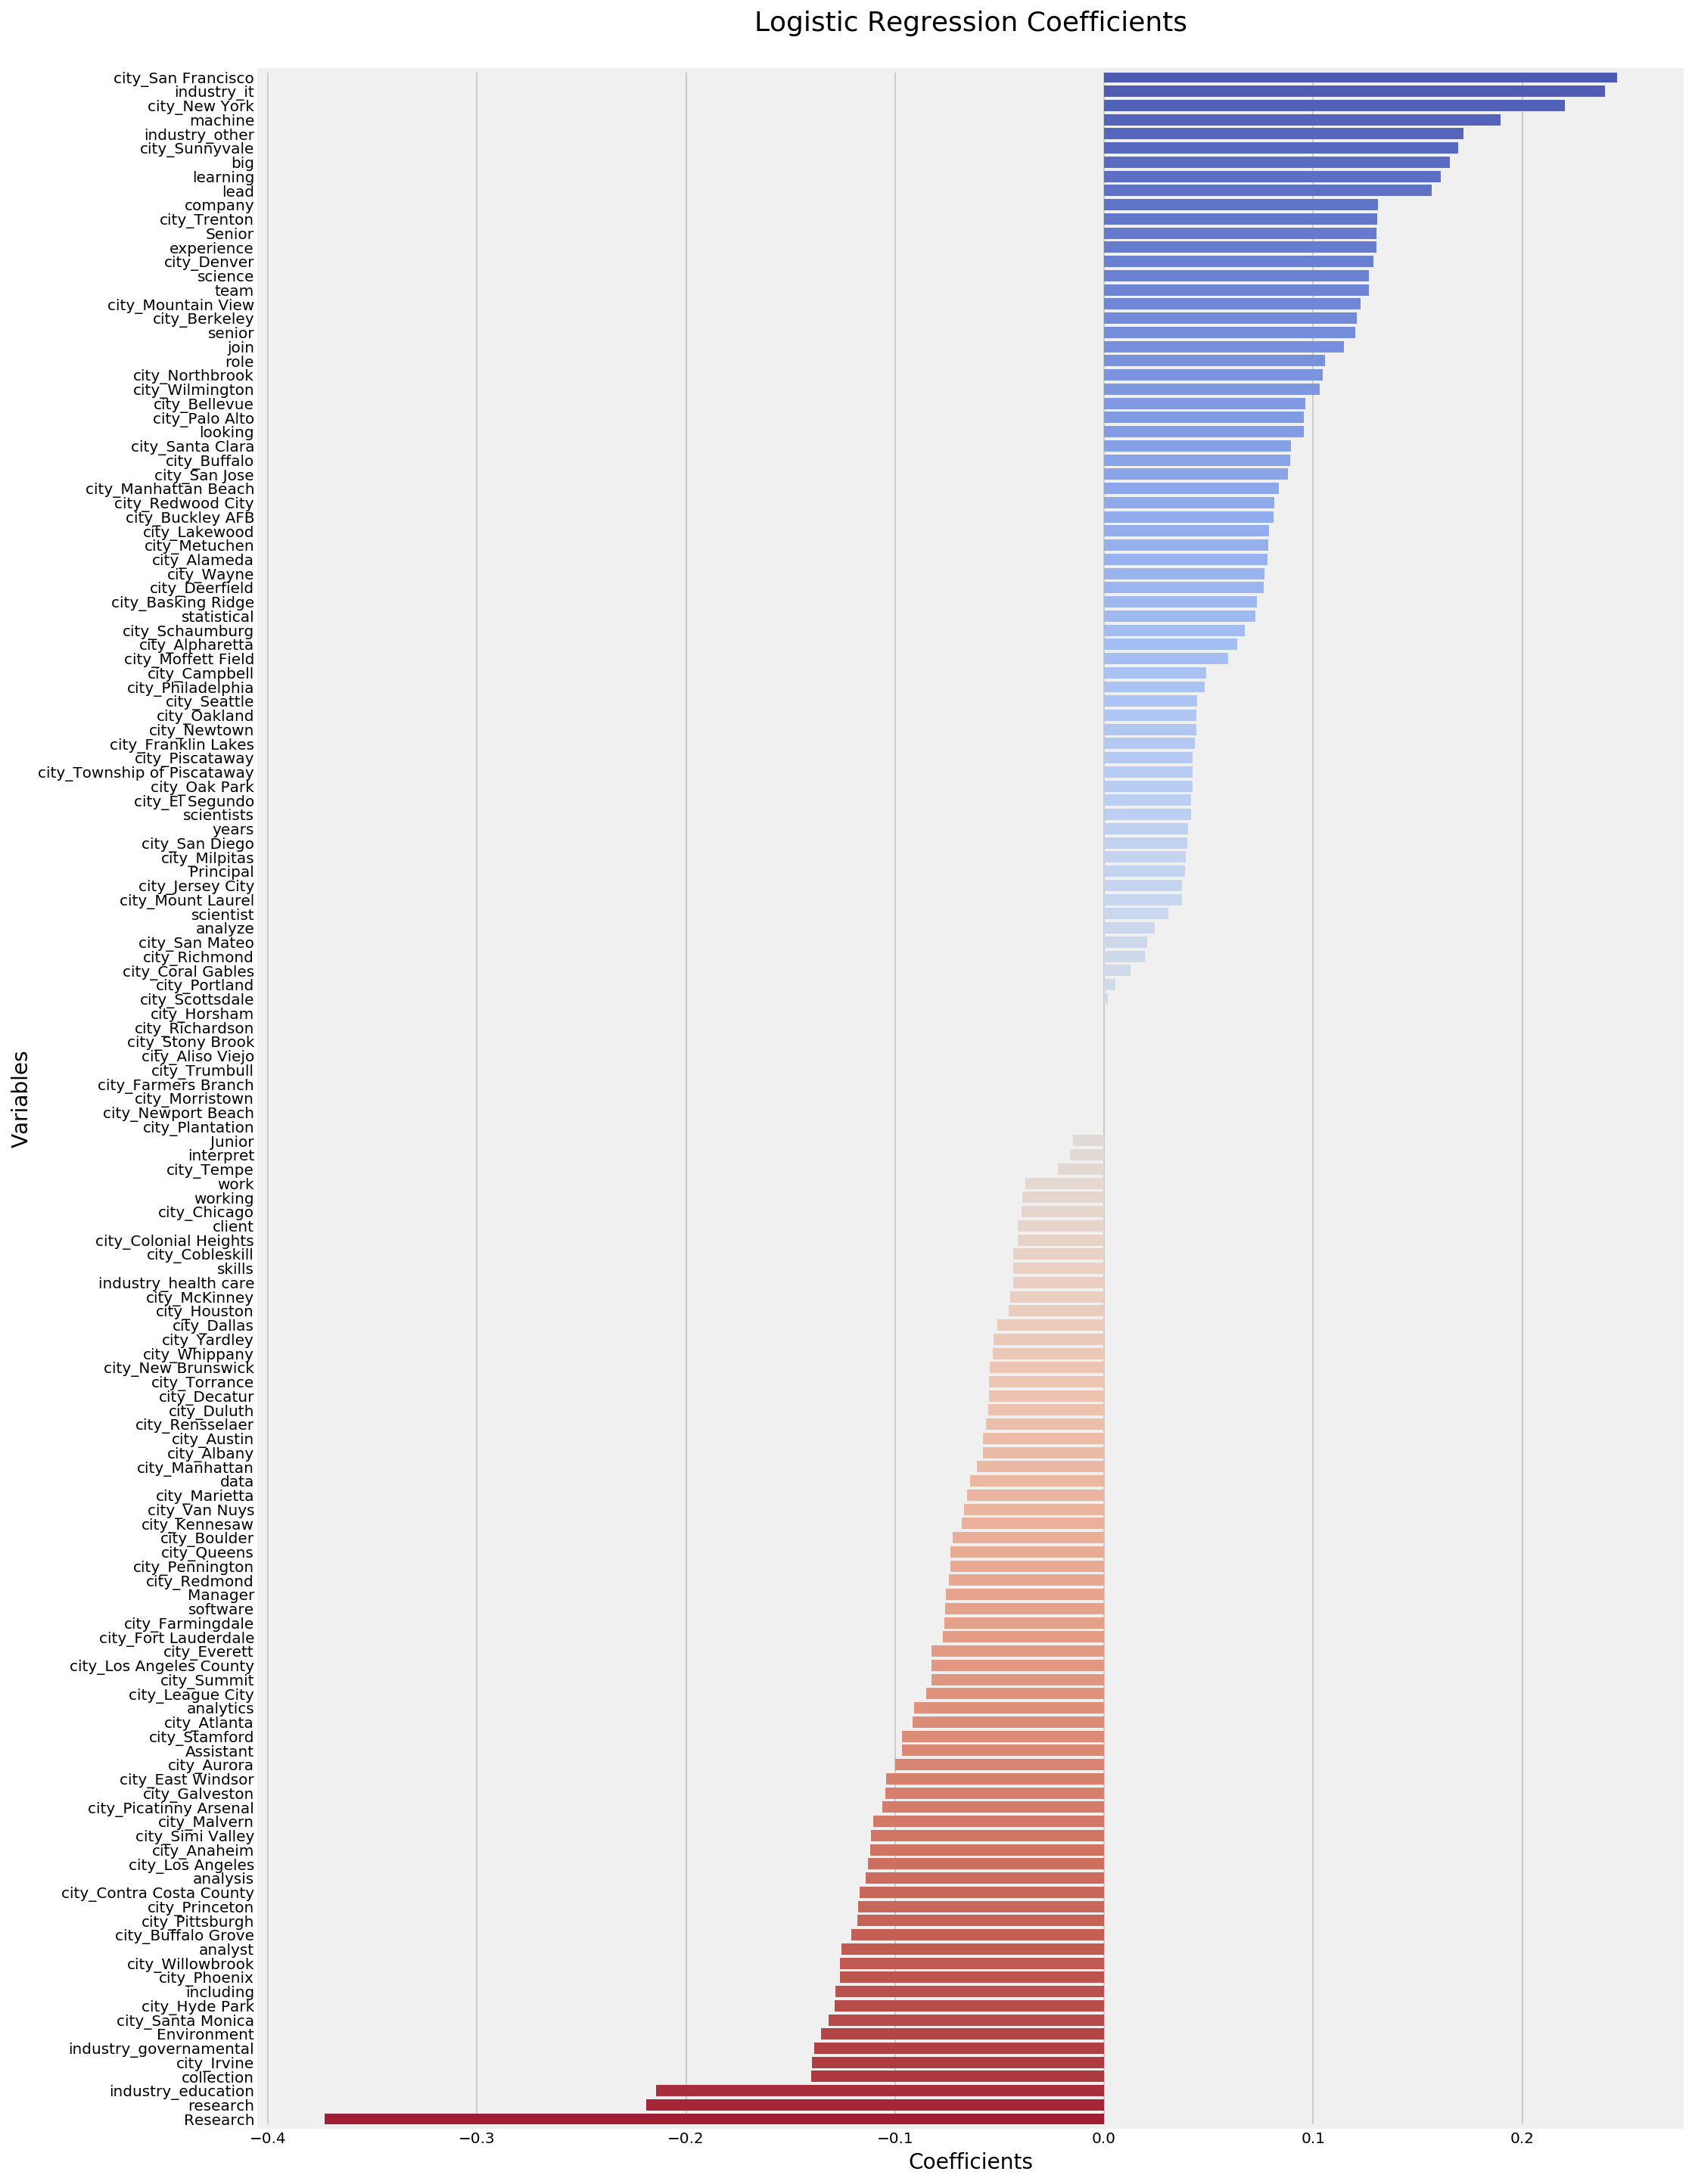

In [96]:
# create a barplot
plt.figure(figsize=(15, 25))
plt.title('Logistic Regression Coefficients\n', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Variables', fontsize=14)
sns.color_palette('coolwarm')
sns.barplot(y=coefs.index, x=coefs.values, orient='h', palette='coolwarm')
sns.color_palette()
plt.show()

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal regularization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [97]:
lr_vec_cv_l1 = LogisticRegressionCV(
    cv=5, n_jobs=-1, Cs=100, solver='liblinear', penalty='l1', verbose=1, max_iter=500)
lr_vec_cv_l1.fit(X_vec_train, y_train)

lr_vec_l1 = LogisticRegression(C=lr_vec_cv_l1.C_[0])

print("Cross validation vectorized features and l1 penalty:\t{:.4f}".format(cross_val_score(lr_vec_l1, X_vec_train, y_train, cv=10).mean()))
lr_vec_l1.fit(X_vec_train, y_train)
yhat_vec = lr_vec_l1.predict(X_vec_test)
y_vec_pp_1 = lr_vec_l1.predict_proba(X_vec_test)[:, 1]

print("Model with l1 penalty and vectorized feats accuracy:\t{:.4f}".format(accuracy_score(y_test, yhat_vec)))
print("Model with l1 penalty and vectorized feats ROC AUC:\t{:.4f}\n".format(roc_auc_score(y_test, y_vec_pp_1)))
print(classification_report(y_test, yhat_vec))

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished


Cross validation vectorized features and l1 penalty:	0.7745
Model with l1 penalty and vectorized feats accuracy:	0.7683
Model with l1 penalty and vectorized feats ROC AUC:	0.8497

             precision    recall  f1-score   support

          0       0.74      0.79      0.77        39
          1       0.80      0.74      0.77        43

avg / total       0.77      0.77      0.77        82



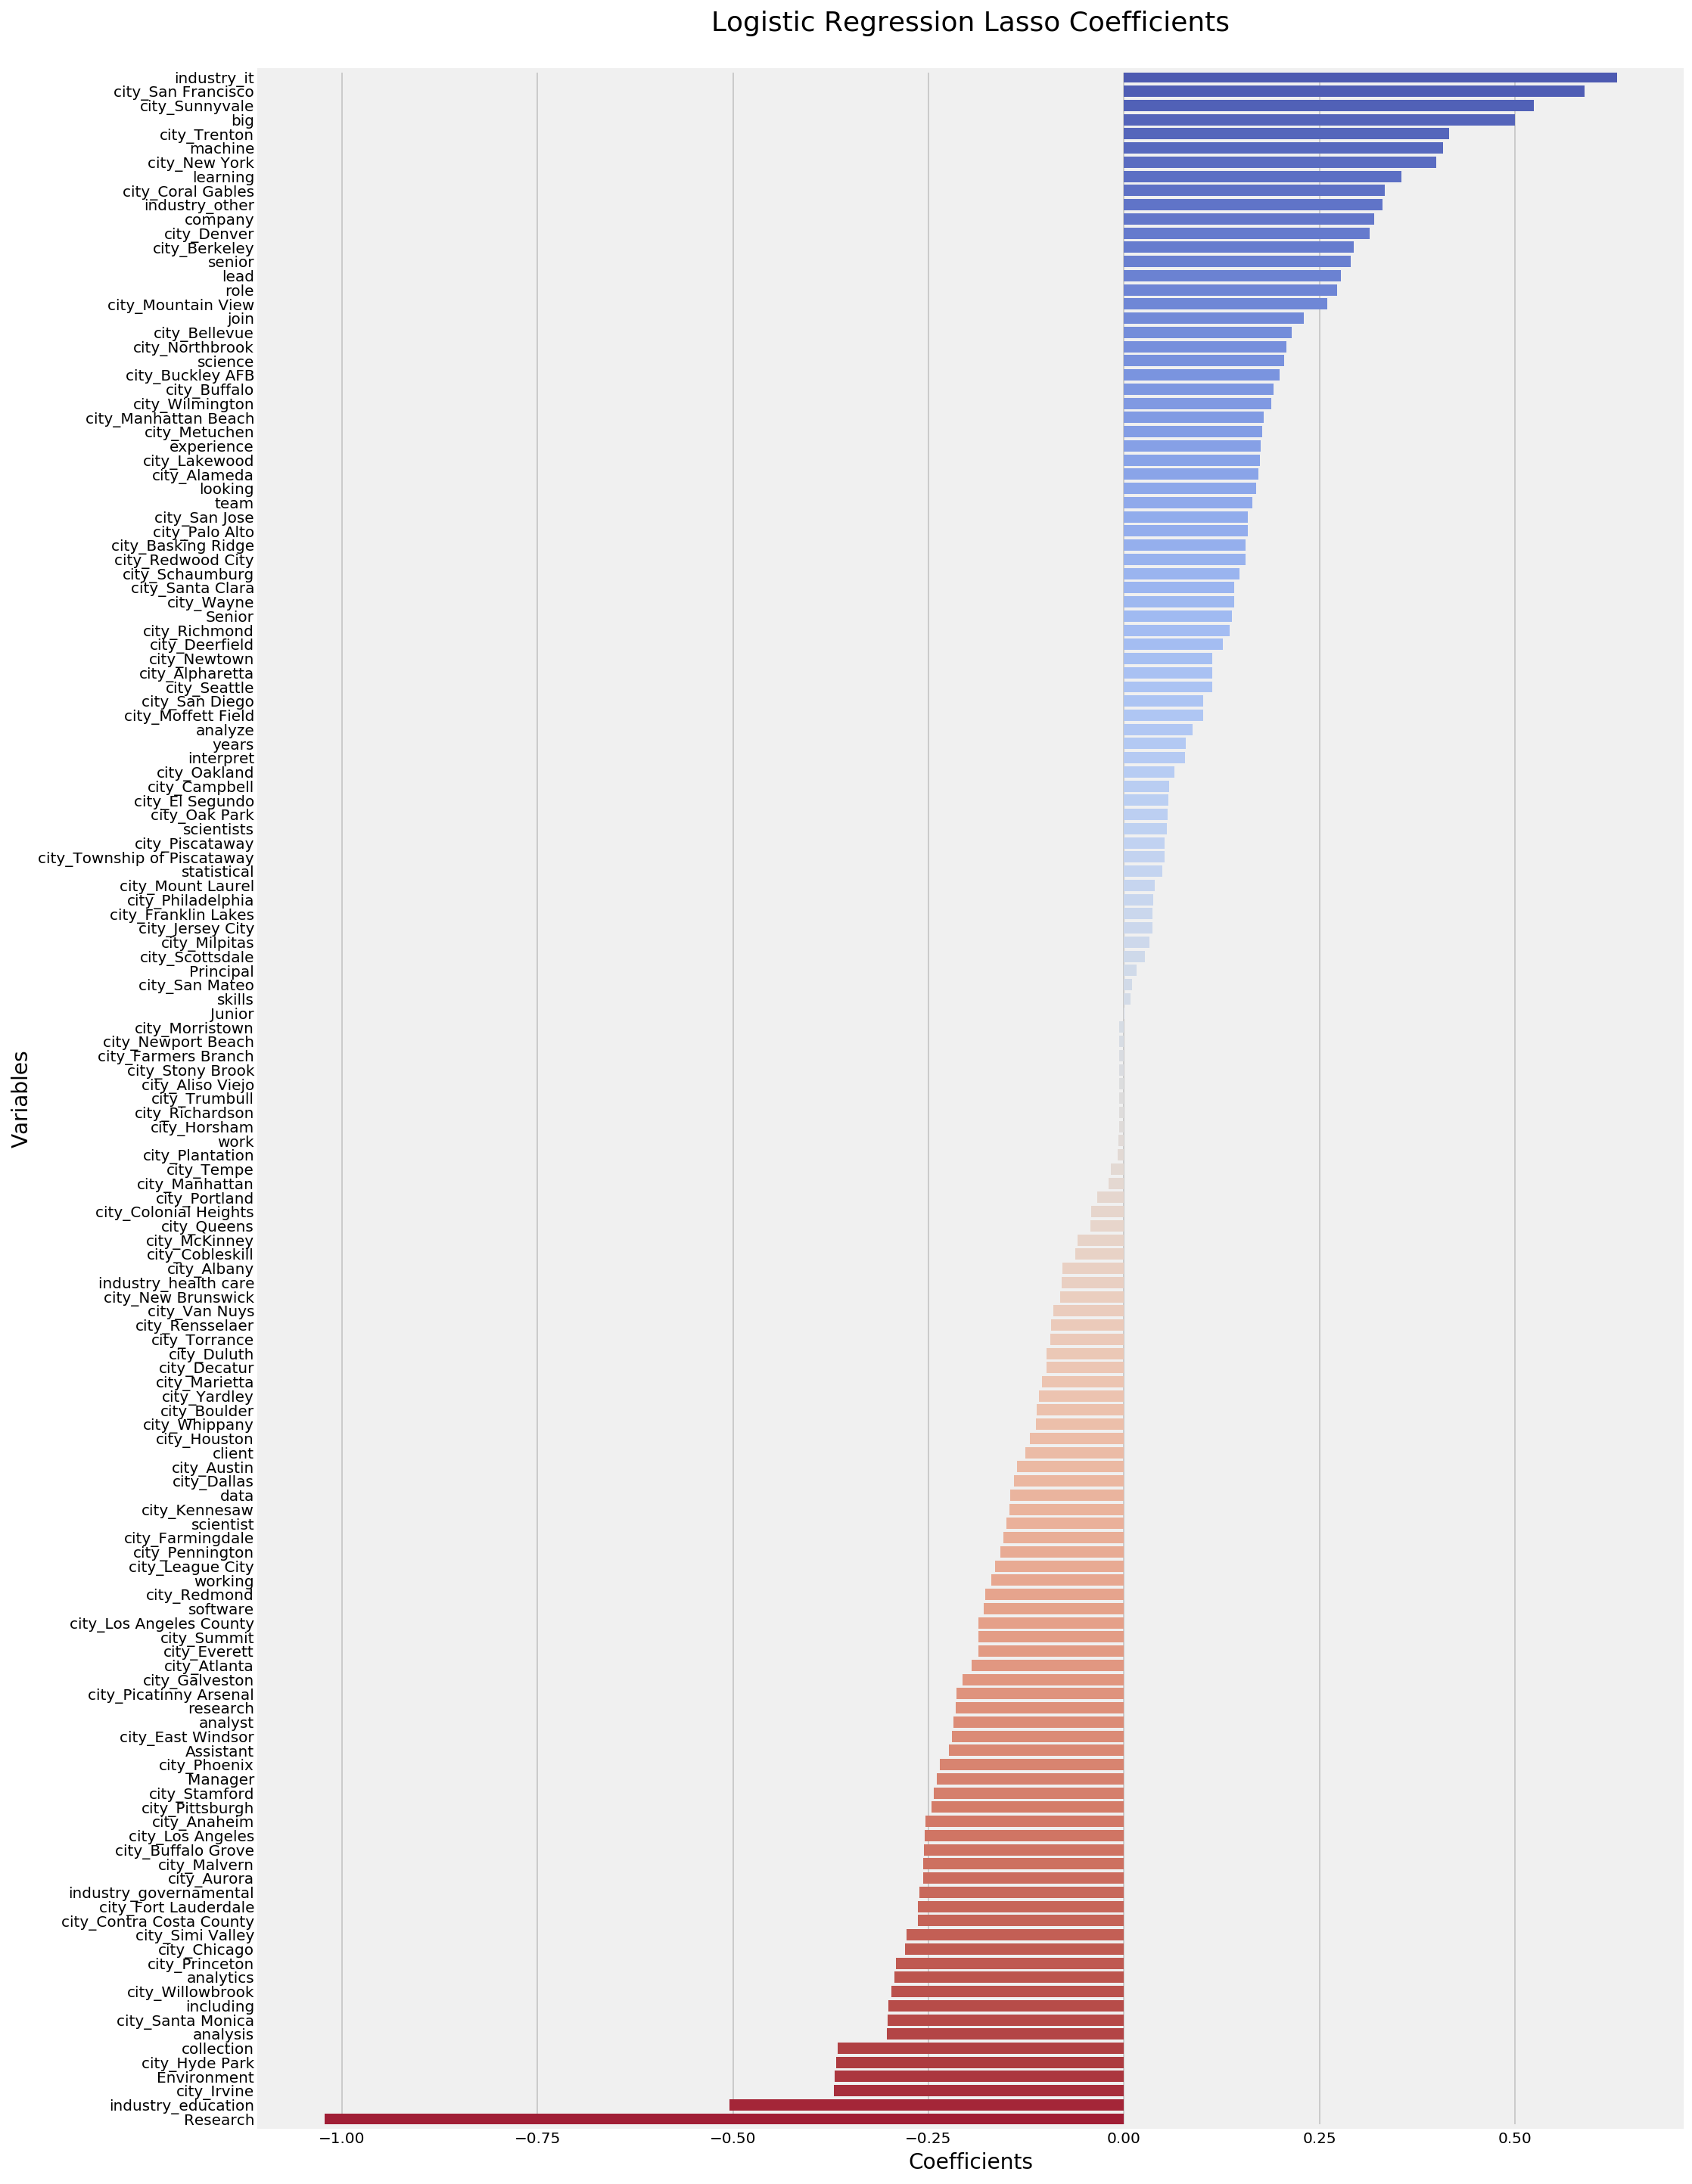

In [98]:
# create a series with the coefficients of the logistic with l1 penalty regression
coefs = pd.Series(data=lr_vec_l1.coef_[0], index=X_vec.columns)

# sort the series
coefs = coefs.sort_values(ascending=False)

# create a barplot
plt.figure(figsize=(15, 25))
plt.title('Logistic Regression Lasso Coefficients\n', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Variables', fontsize=14)
sns.color_palette('coolwarm')
sns.barplot(y=coefs.index, x=coefs.values, orient='h', palette='coolwarm')
sns.color_palette()
plt.show()

In [99]:
lr_vec_cv_l2 = LogisticRegressionCV(cv=5, n_jobs=-1, Cs=1000)
lr_vec_cv_l2.fit(X_vec_train, y_train)

lr_vec_l2 = LogisticRegression(C=lr_vec_cv_l2.C_[0])

print("Cross validation vectorized features and l2 penalty:\t{:.4f}".format(cross_val_score(lr_vec_l2, X_vec_train, y_train, cv=10).mean()))
lr_vec_l2.fit(X_vec_train, y_train)
yhat_vec = lr_vec_l2.predict(X_vec_test)
y_vec_pp_1 = lr_vec_l2.predict_proba(X_vec_test)[:,1]

print("Model with l2 penalty and vectorized feats accuracy:\t{:.4f}".format(accuracy_score(y_test, yhat_vec)))
print("Model with l2 penalty and vectorized feats ROC AUC:\t{:.4f}\n".format(roc_auc_score(y_test, y_vec_pp_1)))
print(classification_report(y_test, yhat_vec))

Cross validation vectorized features and l2 penalty:	0.7777
Model with l2 penalty and vectorized feats accuracy:	0.8415
Model with l2 penalty and vectorized feats ROC AUC:	0.8849

             precision    recall  f1-score   support

          0       0.82      0.85      0.84        39
          1       0.86      0.84      0.85        43

avg / total       0.84      0.84      0.84        82



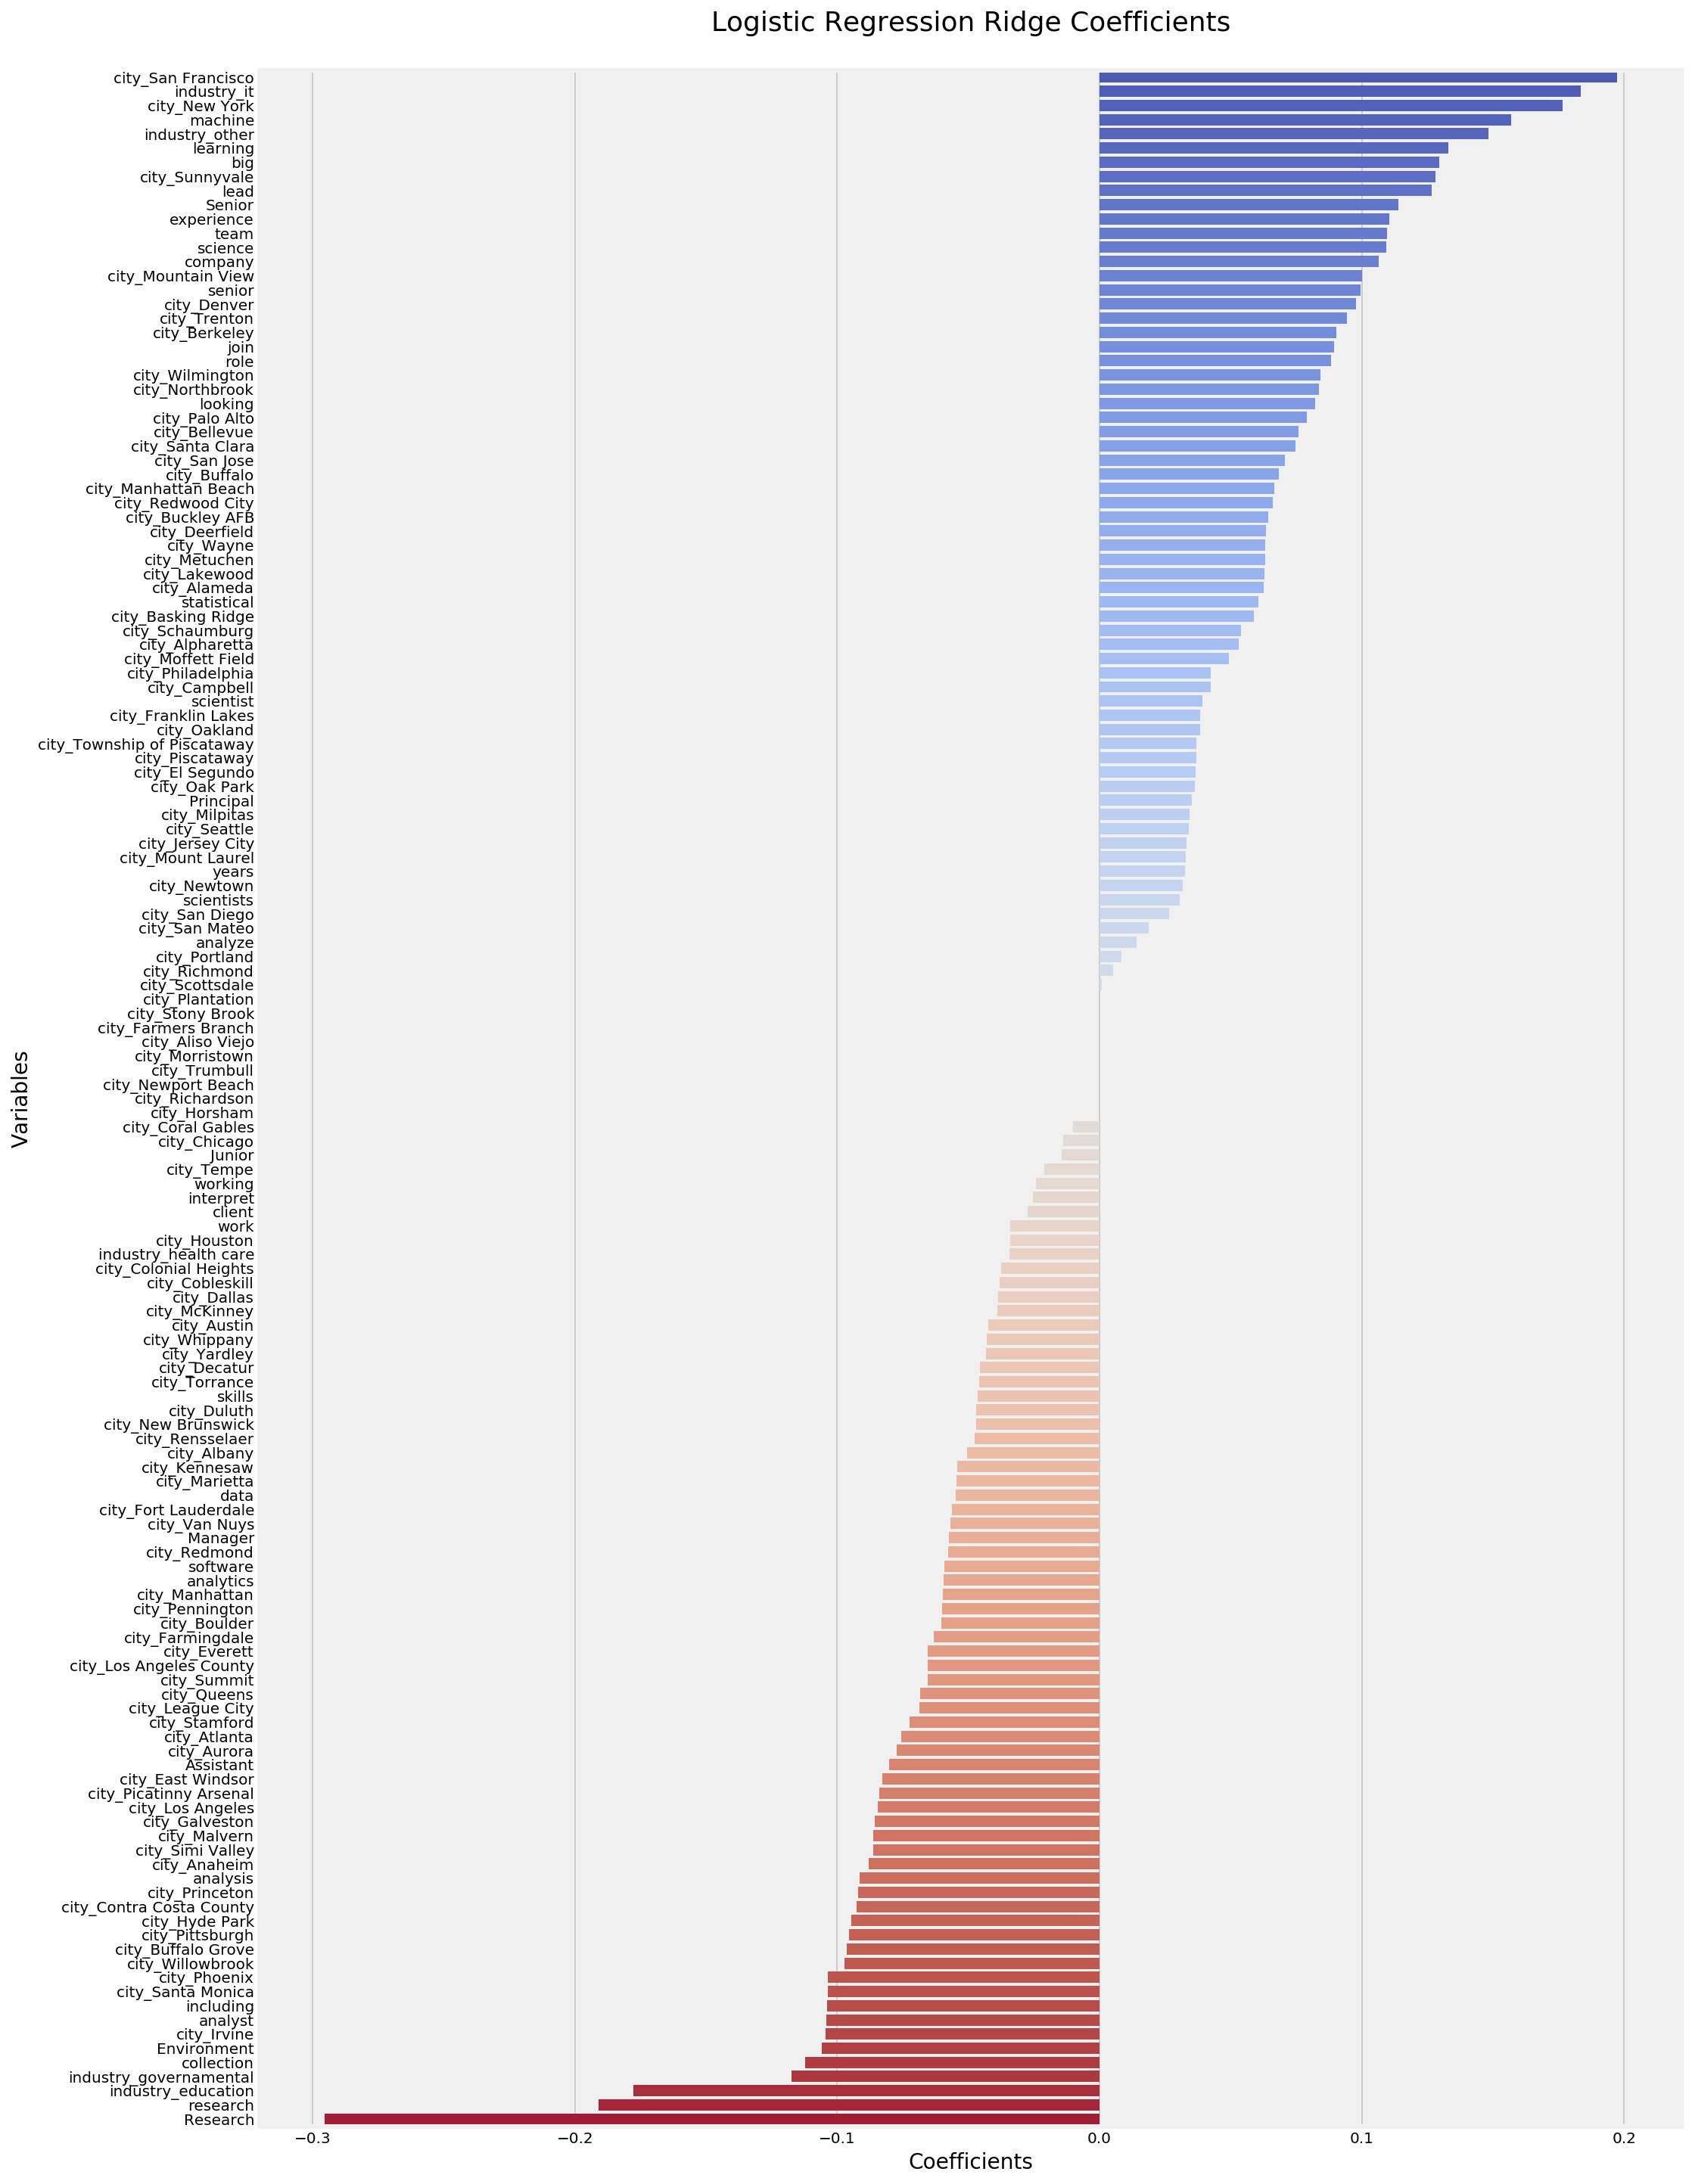

In [100]:
# the Ridge regression created more a smoother distribution of coefficients
# create a series with the coefficients of the logistic with l2 penalty regression
coefs = pd.Series(data=lr_vec_l2.coef_[0], index=X_vec.columns)

# sort the series
coefs = coefs.sort_values(ascending=False)

# create a barplot
plt.figure(figsize=(15, 25))
plt.title('Logistic Regression Ridge Coefficients\n', fontsize=18)
plt.xlabel('Coefficients', fontsize=14)
plt.ylabel('Variables', fontsize=14)
sns.color_palette('coolwarm')
sns.barplot(y=coefs.index, x=coefs.values, orient='h', palette='coolwarm')
sns.color_palette()
plt.show()